In [1]:
import numpy as np
import cvxpy as cp
import sklearn
import sklearn.datasets
from sklearn.ensemble import RandomForestRegressor
import gurobipy
import mosek
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import os
import seaborn as sns
import pandas as pd
# My Code
import LearningMethod as lm
import DataGeneration as dg
import LinearProgramMethod as lpm
import OnlineMethod as om

In [12]:
focus = "degree"
globals()[focus + "_set"] = [1]
total_trial = 30
methods = ['ExpRbf']
for i in range(len(methods)):
    globals()[f"Loss_{methods[i]}"] = np.zeros((total_trial, len(globals()[focus + "_set"])))
    globals()[f"Error_{methods[i]}"] = np.zeros((total_trial, len(globals()[focus + "_set"])))
    globals()[f"Norm_Err_{methods[i]}"] = np.zeros((total_trial, len(globals()[focus + "_set"])))

In [2]:
# Generate Fractional Knapsack Samples
benchmark = 1
dim_features = 5
dim_decision = 10
price = np.random.randint(low=1, high=1000, size=dim_decision)
lower = np.amax(price)
upper = (np.random.rand()-1)*lower + np.sum(price)
Budget = [(upper-lower)*np.random.rand() + lower]
Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_decision, dim_features))
Theta_true = -np.concatenate((Coeff_Mat, np.zeros((dim_decision+1, dim_features))), axis=0)

In [7]:
N_train = 500
# N_valid = 200
N_test = 1000
degree = 1
additive_noise = 0.0
scale_noise_uni = 0.0
scale_noise_div = 0.0
attack_threshold = None
attack_power = 0.0
z_train, c_train, A_train, b_train = dg.GenerateFractionalKnapsack(N_samples=N_train, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                    degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
# z_valid, c_valid, A_valid, b_valid = dg.GenerateFractionalKnapsack(N_samples=N_valid, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
#                                     degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
z_test, c_test, A_test, b_test = dg.GenerateFractionalKnapsack(N_samples=N_test, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                    degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)

In [5]:
# Generate Shortest Path Samples
benchmark = 2
dim_edge_vert = 4
dim_edge_hori = 4
dim_features = 6
dim_cost = dim_edge_hori * (dim_edge_vert + 1) + (dim_edge_hori + 1) * dim_edge_vert
Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_cost, dim_features))

In [6]:
N_train = 200
# N_valid = 200
N_test = 1000
degree = 4
additive_noise = 0.0
scale_noise_uni = 0.0
scale_noise_div = 0.0
attack_threshold = None
attack_power = 0.0
z_train, c_train, A_train, b_train = dg.GenerateShortestPath(N_samples = N_train, dim_features = dim_features, Coeff_Mat=Coeff_Mat,
                                                            dim_edge_vert = dim_edge_vert, dim_edge_hori = dim_edge_hori,
                                                            degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold=attack_threshold, attack_power=attack_power)
# z_valid, c_valid, A_valid, b_valid = dg.GenerateShortestPath(N_samples = N_valid, dim_features = dim_features, Coeff_Mat=Coeff_Mat,
#                                                             dim_edge_vert = dim_edge_vert, dim_edge_hori = dim_edge_hori,
#                                                             degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold=attack_threshold, attack_power=attack_power)
z_test, c_test, A_test, b_test = dg.GenerateShortestPath(N_samples = N_test, dim_features = dim_features, Coeff_Mat=Coeff_Mat,
                                                            dim_edge_vert = dim_edge_vert, dim_edge_hori = dim_edge_hori,
                                                            degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold=attack_threshold, attack_power=attack_power)

In [8]:
# Compute Optimal Solutions
start = time.time()
basic_train, nonb_train, solution_train = lpm.ComputeBasis(c=c_train, A=A_train, b=b_train)
#basic_valid, nonb_valid, solution_valid = lpm.ComputeBasis(c=c_valid, A=A_valid, b=b_valid)
basic_test, nonb_test, solution_test = lpm.ComputeBasis(c=c_test, A=A_test, b=b_test)
print("Time cost", time.time() - start)

Time cost 3.2414863109588623


Method Random Forest
Training samples 1000
Time Cost 0.38739728927612305
Loss 0.21948659456220446 Error 0.49859117315434326 Normalized Error 0.49158763197470406


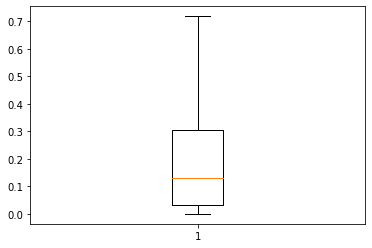

In [18]:
# Tuning Hyperparameters
# Random Forest
# No Theta, directly predict c
alg = 'RF'
print("Method Random Forest")
print("Training samples", N_train)
start = time.time()
regr = RandomForestRegressor(random_state=0)
regr.fit(z_train, c_train)
hat_c = regr.predict(z_test)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark, A=A_test, b=b_test, c=c_test, z=z_test,
                                                                                         direct=True, hat_c=hat_c, solved = True, solution=solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Ordinary Least Squares
Training samples 1000
Time Cost 3.307584762573242
Loss 0.19415475388499986 Error 0.4533149522010404 Normalized Error 0.45179293804347115


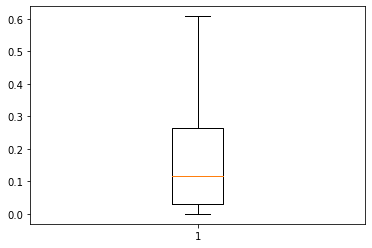

In [19]:
# Tuning Hyperparameters
# Ordinary Least Squares
alg = 'OLS'
print("Method Ordinary Least Squares")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.OrdinaryLeastSquares(A = A_train, b = b_train, c = c_train, z = z_train)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Ridge Regression
Training samples 1000
Time Cost 6.661448001861572
Loss 0.15194116180577058 Error 0.22452946184714642 Normalized Error 0.04323134260851218


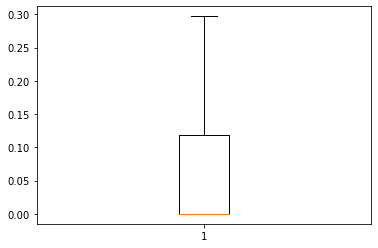

In [33]:
# Tuning Hyperparameters
# Ridge Regression
alg = 'Ridge'
print("Method Ridge Regression")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.RidgeRegression(A = A_train, b = b_train, c = c_train,  z = z_train, regular_const = 1e0)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

In [ ]:
# Tuning Hyperparameters
# Margin Learning
# Do not need true c
# Do not need solution x but basis
alg = 'ML'
print("Method SVM Margin Learning")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.MarginLearning(A = A_train, b = b_train, z = z_train, basic = basic_train, nonb = nonb_train, 
                                            regular_const = 1e-2)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Poly-Kernelized SVM Margin Learning
Training samples 500
Time Cost 50.10742902755737
Loss 0.003481790113631899 Error 2.385362348812643 Normalized Error 0.9626135449495582


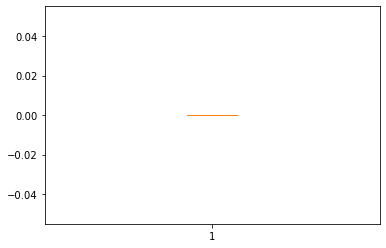

In [106]:
# Tuning Hyperparameters
# Kernelized Margin Learning
# Do not need true c
# Do not need solution x but basis
alg = 'PolyKer'
ker_z_train = lm.PolyKernel(z = z_train, benchmark_z = z_train, gamma=1.0, degree=2, coef0=1.0)
ker_z_test = lm.PolyKernel(z = z_test, benchmark_z = z_train, gamma=1.0, degree=2, coef0=1.0)
print("Method Poly-Kernelized SVM Margin Learning")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.KernelizedMarginLearning(A = A_train, b = b_train, z = ker_z_train, basic = basic_train, nonb = nonb_train,
                                                      regular_const=1e-1)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Rbf Kernelized SVM Margin Learning
Training samples 500
Time Cost 48.845229625701904
Loss 0.001363436132815057 Error 4.356803827566979 Normalized Error 0.9613189211255628


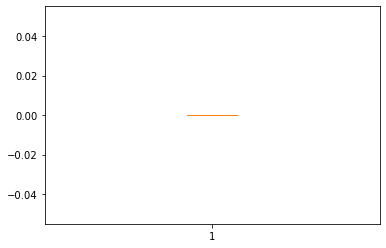

In [9]:
# Tuning Hyperparameters
# Kernelized Margin Learning
# Do not need true c
# Do not need solution x but basis
alg = 'ExpRbf'
ker_z_train = lm.ExpKernel(z = z_train, benchmark_z = z_train, gamma=1e0)
ker_z_test = lm.ExpKernel(z = z_test, benchmark_z = z_train, gamma=1e0)
print("Method Rbf Kernelized SVM Margin Learning")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.KernelizedMarginLearning(A = A_train, b = b_train, z = ker_z_train, basic = basic_train, nonb = nonb_train,
                                                      regular_const=1e-3)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method SPO+
Training samples 1000


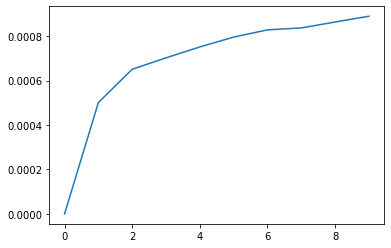

Time Cost 73.65812611579895
Loss 0.5987875151330696 Error 1.0007558631960765 Normalized Error 1.3691127547519202


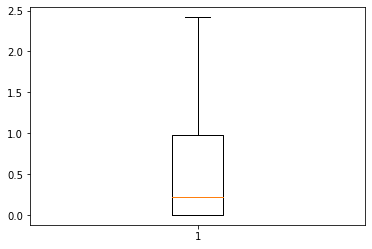

In [12]:
# Tuning Hyperparameters
# SPO+
alg = 'SPO'
print("Method SPO+")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.SPOplus(A = A_train, b = b_train, c = c_train, z = z_train, 
                                     regular_const = 1e-4, step_size = 1e-1, batch_size = 5, max_iter = 1e3, 
                                     solved = True, solution = solution_train)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Naive OGD
Training samples 500
Time Cost 0.006976127624511719
Loss 1.8388770292478134 Error 2.0838786030458283 Normalized Error 1.4042543516428285


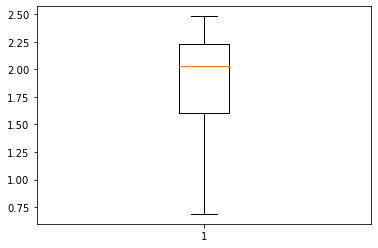

In [17]:
# Tuning Hyperparameters
# Naive Online Gradient Descent
# Do not need true c
alg = 'NOGD'
print("Method Naive OGD")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.NaiveOnlineGradientDescent(A = A_train, b = b_train, z = z_train, 
                                                        step_size = 1e-3, solution = solution_train, radius = 50)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method SVM OGD
Training samples 1000
Time Cost 0.0670003890991211
Loss 0.38048191031371514 Error 0.9994669064078309 Normalized Error 1.3105632225268369


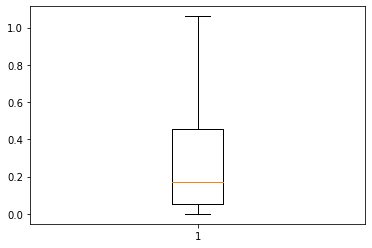

In [17]:
# Tuning Hyperparameters
# SVM Margin Online Gradient Descent
# Do not need true c
# Do not need solution x but basis
alg = 'SVMOGD'
print("Method SVM OGD")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.SVM_OGD(A = A_train, b = b_train, z = z_train, basic = basic_train, nonb = nonb_train,
                                     step_size = 1e-4, radius = 1.1* np.linalg.norm(Coeff_Mat, 'f'), regular_const=1e-2)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

In [ ]:
for trial in range(total_trial):
    # Generate Fractional Knapsack Samples
    benchmark = 1
    dim_features = 5
    dim_decision = 10
    price = np.random.randint(low=1, high=1000, size=dim_decision)
    lower = np.amax(price)
    upper = (np.random.rand()-1)*lower + np.sum(price)
    Budget = [(upper-lower)*np.random.rand() + lower]
    Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_decision, dim_features))
    Theta_true = -np.concatenate((Coeff_Mat, np.zeros((dim_decision+1, dim_features))), axis=0)
    print("*********************************************************")
    print("Trial", trial + 1)
    
    N_train = 500
    # N_valid = 200
    N_test = 1000
    degree = 1
    additive_noise = 0.0
    scale_noise_uni = 0.0
    scale_noise_div = 0.0
    attack_threshold = None
    attack_power = 0.0
    z_train, c_train, A_train, b_train = dg.GenerateFractionalKnapsack(N_samples=N_train, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                        degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    # z_valid, c_valid, A_valid, b_valid = dg.GenerateFractionalKnapsack(N_samples=N_valid, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
    #                                     degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    z_test, c_test, A_test, b_test = dg.GenerateFractionalKnapsack(N_samples=N_test, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                        degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    # Compute Optimal Solutions
    start = time.time()
    basic_train, nonb_train, solution_train = lpm.ComputeBasis(c=c_train, A=A_train, b=b_train)
    #basic_valid, nonb_valid, solution_valid = lpm.ComputeBasis(c=c_valid, A=A_valid, b=b_valid)
    basic_test, nonb_test, solution_test = lpm.ComputeBasis(c=c_test, A=A_test, b=b_test)
    print("Time cost", time.time() - start)
    
    
    # Kernelized Margin Learning
    # Do not need true c
    # Do not need solution x but basis
    alg = 'ExpRbf'
    ker_z_train = lm.ExpKernel(z = z_train, benchmark_z = z_train, gamma=1e-1)
    ker_z_test = lm.ExpKernel(z = z_test, benchmark_z = z_train, gamma=1e-1)
    print("Method Kernelized SVM Margin Learning")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.KernelizedMarginLearning(A = A_train, b = b_train, z = ker_z_train, basic = basic_train, nonb = nonb_train,
                                                          regular_const=0)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])

*********************************************************
Trial 1
Time cost 3.4068288803100586
Method Kernelized SVM Margin Learning
Training samples 500


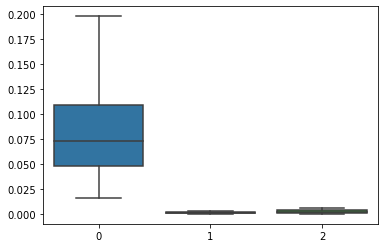

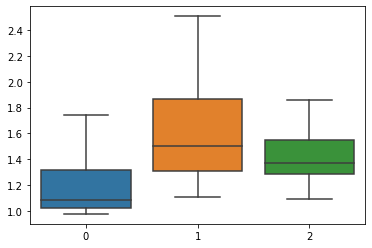

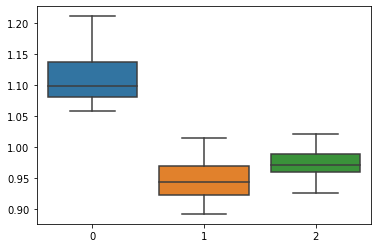

In [59]:
# degree 4
i = 0
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Degree', f"{data}_degree_{degree_set[i]}_Ker"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

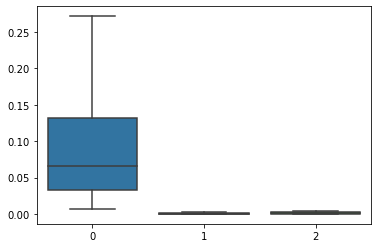

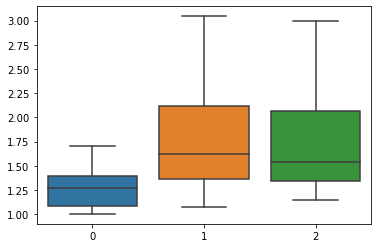

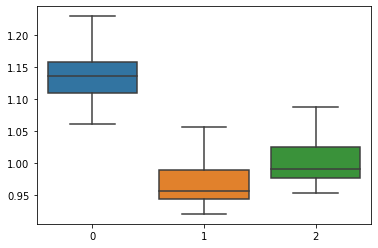

In [95]:
# degree 6
i = 1
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Degree', f"{data}_degree_{degree_set[i]}_Ker"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

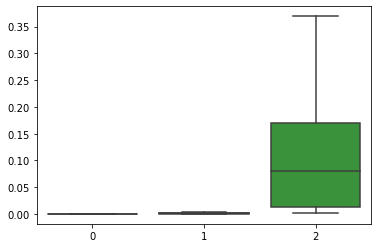

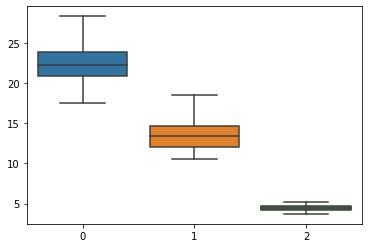

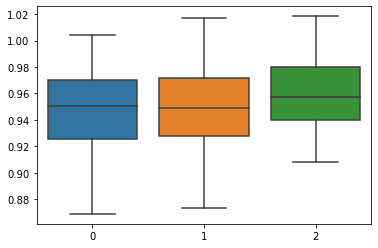

In [112]:
# degree 1
i = 2
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Degree', f"{data}_degree_{degree_set[i]}_Ker"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

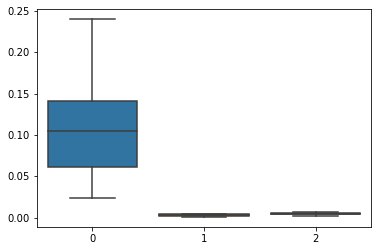

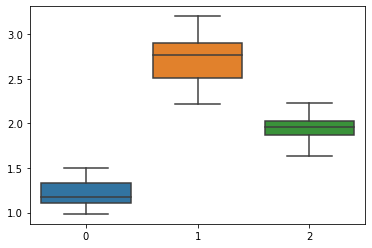

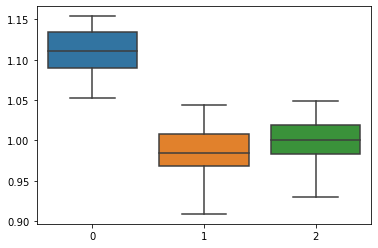

In [110]:
# degree 2
i = 3
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Degree', f"{data}_degree_{degree_set[i]}_Ker"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

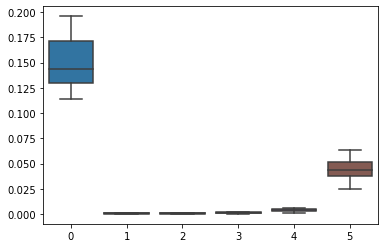

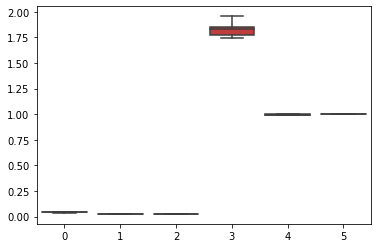

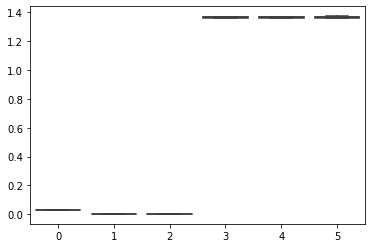

In [36]:
i = 0
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Attack_Power', f"{data}_power_{attack_power_set[i]}"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

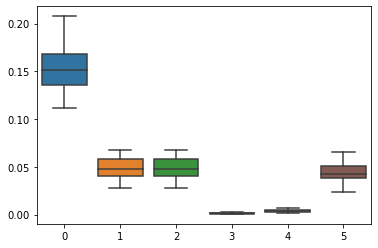

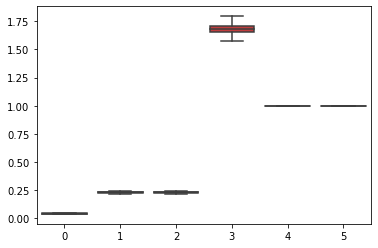

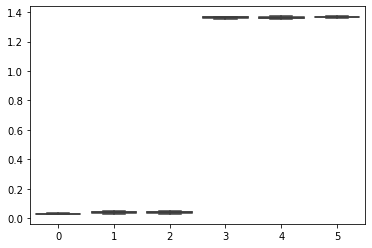

In [4]:
i = 1
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Attack_Power', f"{data}_power_{attack_power_set[i]}"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

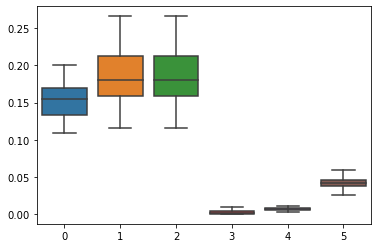

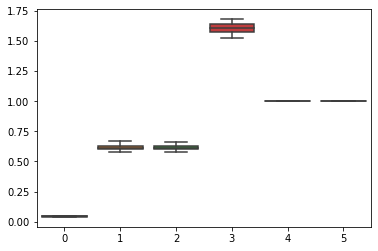

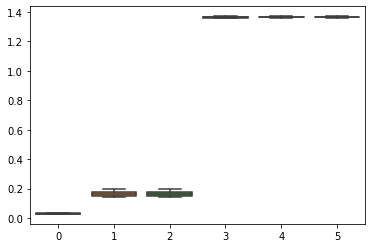

In [14]:
i = 2
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Attack_Power', f"{data}_power_{attack_power_set[i]}"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

In [24]:
print(globals()[data+"_"+methods[j]].T[i])

[0.12922369 0.11743162 0.16924198 0.16297437 0.13077465 0.15823413
 0.14790405 0.17031298 0.15833414 0.18191709 0.15625121 0.19096635
 0.15535143 0.15031566 0.18060388 0.15342378 0.12405103 0.21309579
 0.11811923 0.15956173 0.14396253 0.1942669  0.13780931 0.15165267
 0.12863871 0.15474835 0.12454046 0.13749102 0.17122848 0.17815233]


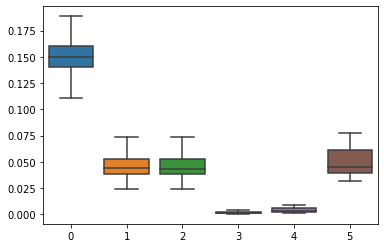

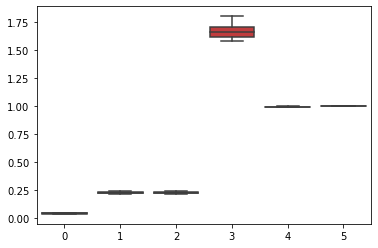

In [32]:
i = 1
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Attack_Power', f"Loss_power{attack_power_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Attack_Power', f"Error_power{attack_power_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

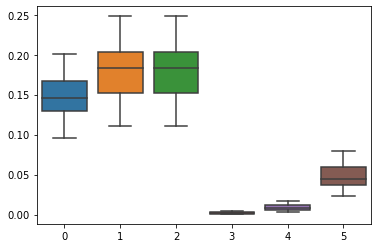

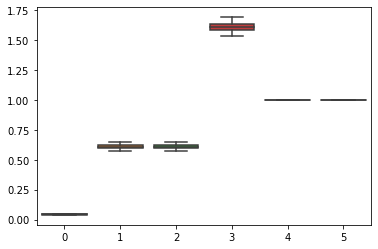

In [46]:
i = 2
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Attack_Power', f"Loss_power{attack_power_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Attack_Power', f"Error_power{attack_power_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

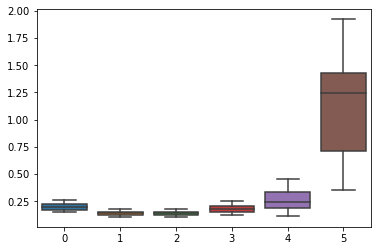

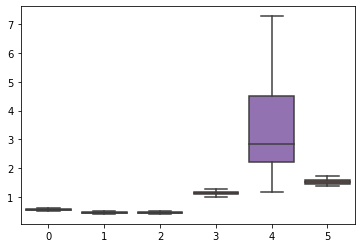

In [212]:
i = 0
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Loss_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Error_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

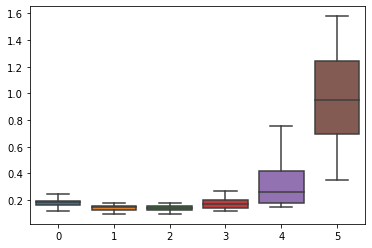

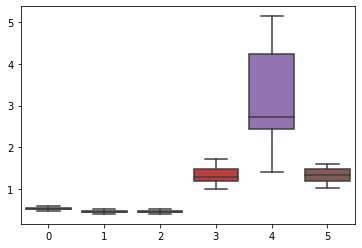

In [255]:
i = 1
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Loss_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Error_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

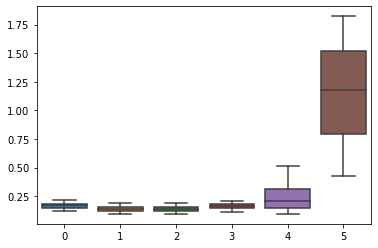

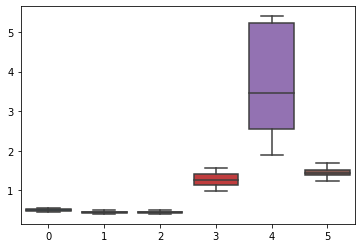

In [334]:
i = 2
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Loss_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Error_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

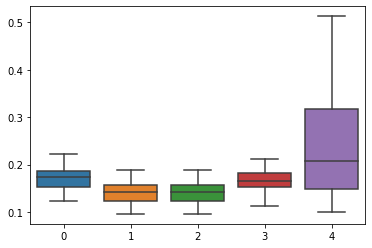

In [341]:
data = np.loadtxt(os.path.join('Sample_Complexity', 'Loss_N500'))
data = data[:, :-1]
sns.boxplot(data = data, showfliers = False)
plt.show()

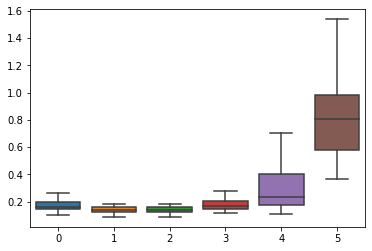

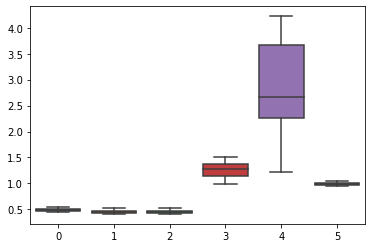

In [314]:
i = 3
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Loss_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Error_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

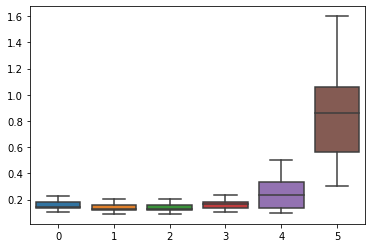

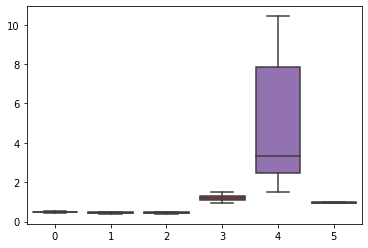

In [288]:
i = 4
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Loss_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Error_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

In [23]:
for trial in range(total_trial):
    # Generate Fractional Knapsack Samples
    benchmark = 1
    dim_features = 5
    dim_decision = 10
    price = np.random.randint(low=1, high=1000, size=dim_decision)
    lower = np.amax(price)
    upper = (np.random.rand()-1)*lower + np.sum(price)
    Budget = [(upper-lower)*np.random.rand() + lower]
    Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_decision, dim_features))
    Theta_true = -np.concatenate((Coeff_Mat, np.zeros((dim_decision+1, dim_features))), axis=0)
    print("*********************************************************")
    print("Trial", trial + 1)
    
    N_train = 1000
    # N_valid = 200
    N_test = 1000
    degree = 1
    additive_noise = 1.0
    scale_noise_uni = 0.0
    scale_noise_div = 0.1
    attack_threshold = None
    attack_power = 0.0
    z_train, c_train, A_train, b_train = dg.GenerateFractionalKnapsack(N_samples=N_train, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                        degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    # z_valid, c_valid, A_valid, b_valid = dg.GenerateFractionalKnapsack(N_samples=N_valid, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
    #                                     degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    z_test, c_test, A_test, b_test = dg.GenerateFractionalKnapsack(N_samples=N_test, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                        degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    # Compute Optimal Solutions
    start = time.time()
    basic_train, nonb_train, solution_train = lpm.ComputeBasis(c=c_train, A=A_train, b=b_train)
    #basic_valid, nonb_valid, solution_valid = lpm.ComputeBasis(c=c_valid, A=A_valid, b=b_valid)
    basic_test, nonb_test, solution_test = lpm.ComputeBasis(c=c_test, A=A_test, b=b_test)
    print("Time cost", time.time() - start)
    alg = 'SVMOGD'
    print("Method SVM OGD")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.SVM_OGD(A = A_train, b = b_train, z = z_train, basic = basic_train, nonb = nonb_train,
                                         step_size = 1e-2, radius = 1.1* np.linalg.norm(Coeff_Mat, 'f'), regular_const=1e-2)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])

*********************************************************
Trial 1
Time cost 3.6999521255493164
Method SVM OGD
Training samples 1000
Time Cost 0.06500387191772461
Loss 1.0836694526116781 Error 1.0859294662152639 Normalized Error 1.2053681412648827
*********************************************************
Trial 2
Time cost 3.4948089122772217
Method SVM OGD
Training samples 1000
Time Cost 0.06355476379394531
Loss 1.333529194882512 Error 1.1139861226262462 Normalized Error 1.2817227296040534
*********************************************************
Trial 3
Time cost 3.4894750118255615
Method SVM OGD
Training samples 1000
Time Cost 0.06600213050842285
Loss 0.3224817722222044 Error 0.968624193690609 Normalized Error 1.1966951492979678
*********************************************************
Trial 4
Time cost 3.551055431365967
Method SVM OGD
Training samples 1000
Time Cost 0.06404566764831543
Loss 1.1145710659641723 Error 1.146740841065964 Normalized Error 1.2475662809536079
****************

KeyboardInterrupt: 

In [22]:
print(np.average(globals()["Loss_" + alg][trial][mark]))

0.944507443916253


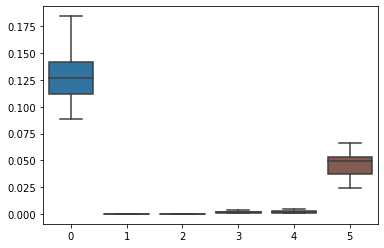

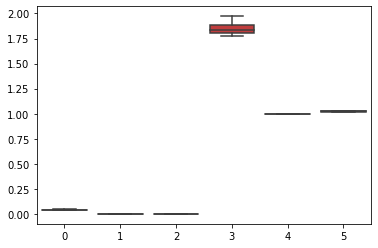

In [121]:
i = 0
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Loss_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Error_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

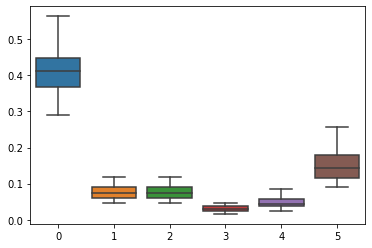

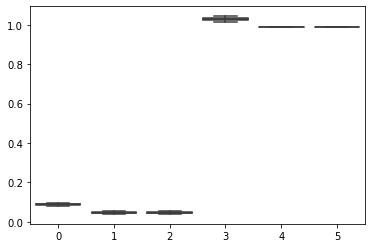

In [122]:
i = 1
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Loss_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Error_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

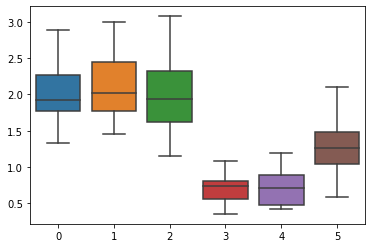

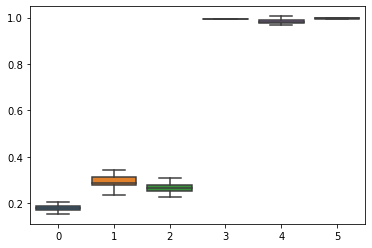

In [123]:
i = 2
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Loss_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Error_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

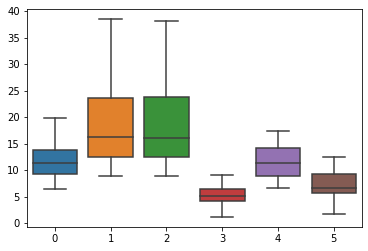

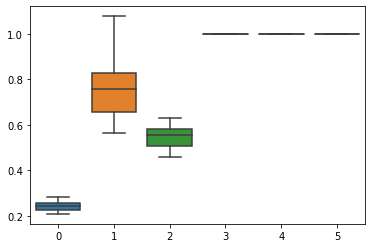

In [125]:
i = 3
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Loss_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Error_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

In [161]:
np.savetxt(os.path.join('Sample_Complexity', "RegretSP_N"), [Reg_RF[0], Reg_ML[0], Reg_Ridge[0], Reg_OLS[0], Reg_SPO[0], Reg_NOGD[0], Reg_SVMOGD[0]])
np.savetxt(os.path.join('Sample_Complexity', "ErrorSP_N"), [Err_RF[0], Err_ML[0], Err_Ridge[0], Err_OLS[0], Err_SPO[0], Err_NOGD[0], Err_SVMOGD[0]])

In [137]:
N_set = [100, 200, 500, 1000, 2000, 5000]
for N in N_set:
    [globals()[f"Regret_RF_{N}"], globals()[f"Regret_ML_{N}"], globals()[f"Regret_Ridge_{N}"],
     globals()[f"Regret_OLS_{N}"], globals()[f"Regret_SPO_{N}"], globals()[f"Regret_NOGD_{N}"], 
     globals()[f"Regret_SVMOGD_{N}"]] = np.loadtxt(os.path.join('Sample_Complexity', "RegretFK_N{}".format(N)))
    [globals()[f"Error_RF_{N}"], globals()[f"Error_ML_{N}"], globals()[f"Error_Ridge_{N}"],
     globals()[f"Error_OLS_{N}"], globals()[f"Error_SPO_{N}"], globals()[f"Error_NOGD_{N}"],
     globals()[f"Error_SVMOGD_{N}"]] = np.loadtxt(os.path.join('Sample_Complexity', "ErrorFK_N{}".format(N)))


In [140]:
regret = []
error = []
columns = []
for N in N_set:
    regret = regret + [globals()[f"Regret_RF_{N}"], globals()[f"Regret_Ridge_{N}"], globals()[f"Regret_OLS_{N}"],
                              globals()[f"Regret_ML_{N}"], globals()[f"Regret_SPO_{N}"], globals()[f"Regret_NOGD_{N}"], 
                              globals()[f"Regret_SVMOGD_{N}"]]
    error = error + [globals()[f"Error_RF_{N}"], globals()[f"Error_Ridge_{N}"], globals()[f"Error_OLS_{N}"],
                              globals()[f"Error_ML_{N}"], globals()[f"Error_SPO_{N}"], globals()[f"Error_NOGD_{N}"], 
                              globals()[f"Error_SVMOGD_{N}"]]
    columns = columns + [f"RF, {N}", f"Ridge, {N}", f"OLS, {N}", f"ML, {N}", f"SPO, {N}", f"NOGD, {N}", f"SVMOGD, {N}"]
data_reg = pd.DataFrame(np.array(regret).T, columns = columns)
data_err = pd.DataFrame(np.array(error).T, columns = columns)

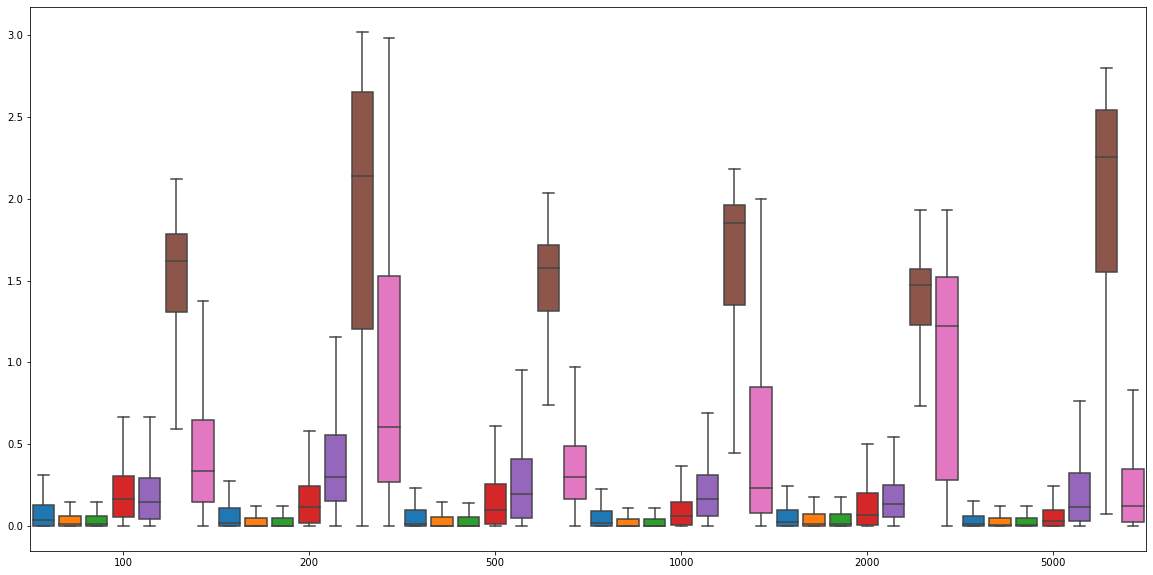

In [143]:
methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_reg, showfliers=False)
xticks = []
xticklabels = []
for i in range(len(N_set)):
    xticks.append(int(len(methods)/2) + i * len(methods))
    xticklabels.append(f'{N_set[i]}')
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

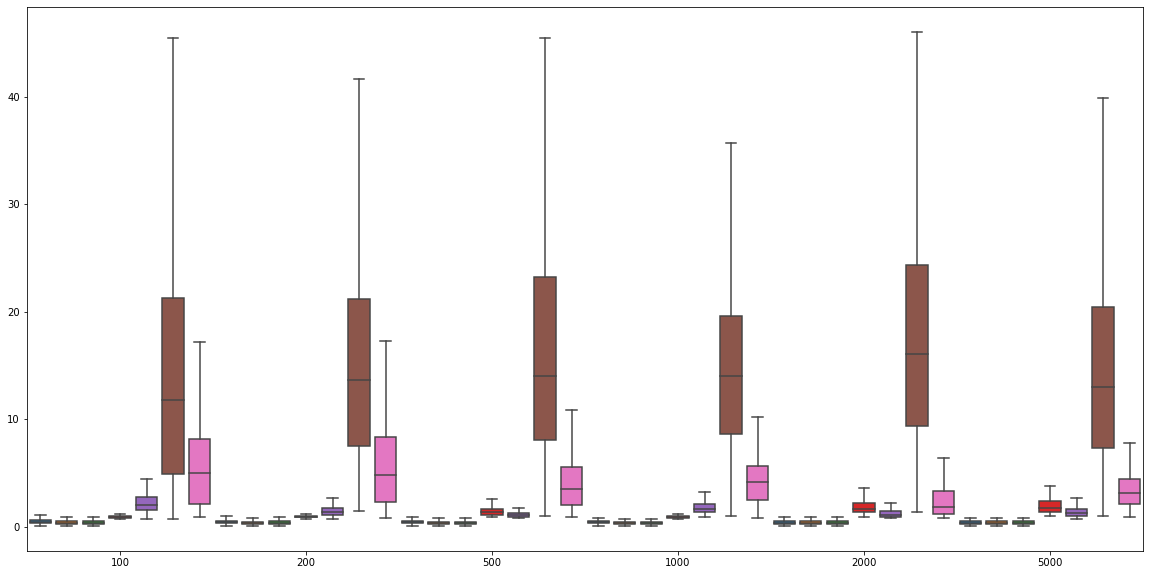

In [144]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_err, showfliers=False)
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

In [250]:
dim_set = [6, 8, 10, 12, 14]
for dim in dim_set:
    [globals()[f"Regret_RF_{dim}"], globals()[f"Regret_ML_{dim}"], globals()[f"Regret_Ridge_{dim}"],
     globals()[f"Regret_OLS_{dim}"], globals()[f"Regret_SPO_{dim}"], globals()[f"Regret_NOGD_{dim}"], 
     globals()[f"Regret_SVMOGD_{dim}"]] = np.loadtxt(os.path.join('Problem_Size', "RegretFK_dim{}".format(dim)))
    [globals()[f"Error_RF_{dim}"], globals()[f"Error_ML_{dim}"], globals()[f"Error_Ridge_{dim}"],
     globals()[f"Error_OLS_{dim}"], globals()[f"Error_SPO_{dim}"], globals()[f"Error_NOGD_{dim}"],
     globals()[f"Error_SVMOGD_{dim}"]] = np.loadtxt(os.path.join('Problem_Size', "ErrorFK_dim{}".format(dim)))


In [253]:
regret = []
error = []
columns = []
for dim in dim_set:
    regret = regret + [globals()[f"Regret_RF_{dim}"], globals()[f"Regret_Ridge_{dim}"],
                 globals()[f"Regret_OLS_{dim}"], globals()[f"Regret_ML_{dim}"], globals()[f"Regret_SPO_{dim}"], globals()[f"Regret_NOGD_{dim}"], 
                 globals()[f"Regret_SVMOGD_{dim}"]]
    error = error + [globals()[f"Error_RF_{dim}"], globals()[f"Error_Ridge_{dim}"],
                 globals()[f"Error_OLS_{dim}"], globals()[f"Error_ML_{dim}"], globals()[f"Error_SPO_{dim}"], globals()[f"Error_NOGD_{dim}"],
                 globals()[f"Error_SVMOGD_{dim}"]]
    columns = columns + [f"RF, {dim}", f"Ridge, {dim}", f"OLS, {dim}", f"ML, {dim}", f"SPO, {dim}", f"NOGD, {dim}", f"SVMOGD, {dim}"]
data_reg = pd.DataFrame(np.array(regret).T, columns = columns)
data_err = pd.DataFrame(np.array(error).T, columns = columns)

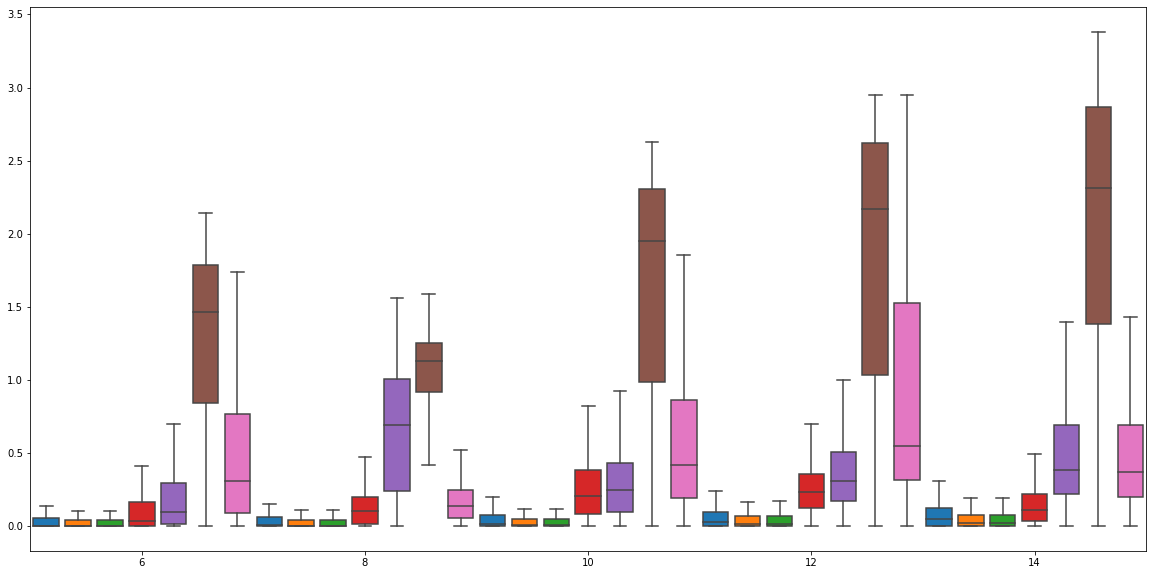

In [254]:
methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_reg, showfliers=False)
xticks = []
xticklabels = []
for i in range(len(dim_set)):
    xticks.append(int(len(methods)/2) + i * len(methods))
    xticklabels.append(f'{dim_set[i]}')
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

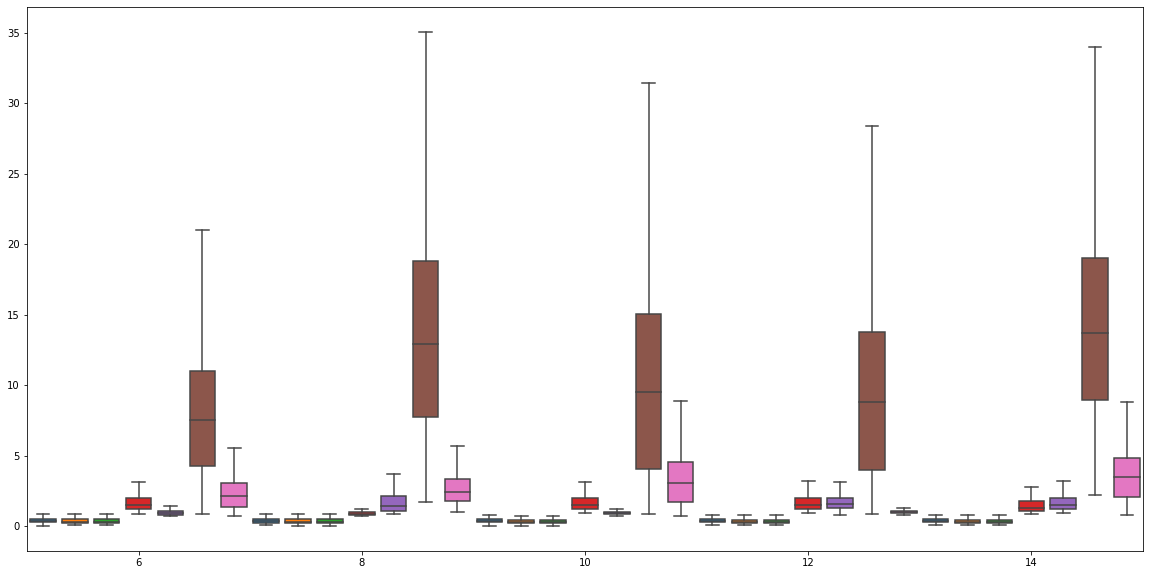

In [255]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_err, showfliers=False)
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

In [390]:
AN_set = [0.1, 0.3, 0.5, 0.7, 0.9]
for an in AN_set:
    [globals()[f"Regret_RF_{an}"], globals()[f"Regret_ML_{an}"], globals()[f"Regret_Ridge_{an}"],
     globals()[f"Regret_OLS_{an}"], globals()[f"Regret_SPO_{an}"], globals()[f"Regret_NOGD_{an}"], 
     globals()[f"Regret_SVMOGD_{an}"]] = np.loadtxt(os.path.join('Additive_Noise', "RegretFK_AN{}".format(an)))
    [globals()[f"Error_RF_{an}"], globals()[f"Error_ML_{an}"], globals()[f"Error_Ridge_{an}"],
     globals()[f"Error_OLS_{an}"], globals()[f"Error_SPO_{an}"], globals()[f"Error_NOGD_{an}"],
     globals()[f"Error_SVMOGD_{an}"]] = np.loadtxt(os.path.join('Additive_Noise', "ErrorFK_AN{}".format(an)))


In [391]:
regret = []
error = []
columns = []
for an in AN_set:
    regret = regret + [globals()[f"Regret_RF_{an}"], globals()[f"Regret_Ridge_{an}"],
                 globals()[f"Regret_OLS_{an}"], globals()[f"Regret_ML_{an}"], globals()[f"Regret_SPO_{an}"], globals()[f"Regret_NOGD_{an}"], 
                 globals()[f"Regret_SVMOGD_{an}"]]
    error = error + [globals()[f"Error_RF_{an}"], globals()[f"Error_Ridge_{an}"],
                 globals()[f"Error_OLS_{an}"], globals()[f"Error_ML_{an}"], globals()[f"Error_SPO_{an}"], globals()[f"Error_NOGD_{an}"],
                 globals()[f"Error_SVMOGD_{an}"]]
    columns = columns + [f"RF, {an}", f"Ridge, {an}", f"OLS, {an}", f"ML, {an}", f"SPO, {an}", f"NOGD, {an}", f"SVMOGD, {an}"]
data_reg = pd.DataFrame(np.array(regret).T, columns = columns)
data_err = pd.DataFrame(np.array(error).T, columns = columns)

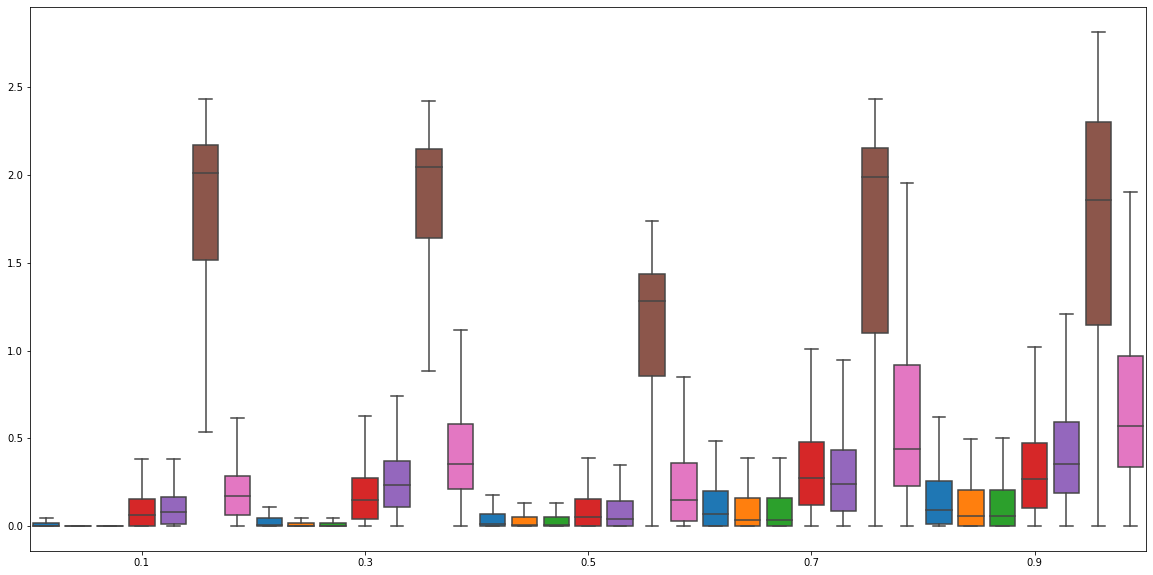

In [392]:
methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_reg, showfliers=False)
xticks = []
xticklabels = []
for i in range(len(AN_set)):
    xticks.append(int(len(methods)/2) + i * len(methods))
    xticklabels.append(f'{AN_set[i]}')
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

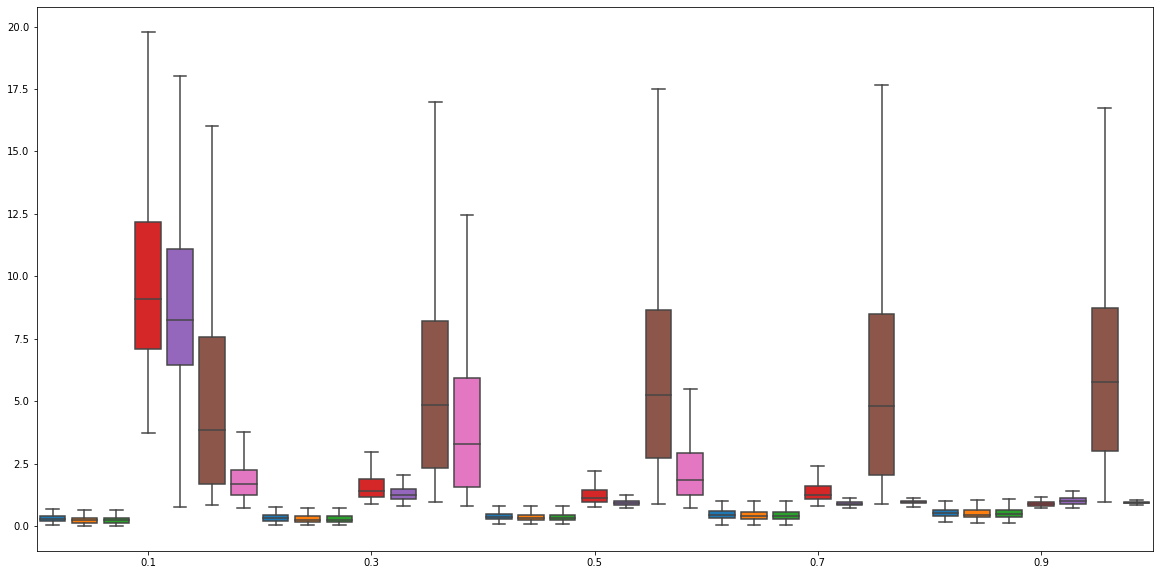

In [393]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_err, showfliers=False)
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

In [500]:
SN_set = [0.1, 0.3, 0.5, 0.7, 0.9]
for sn in SN_set:
    [globals()[f"Regret_RF_{sn}"], globals()[f"Regret_ML_{sn}"], globals()[f"Regret_Ridge_{sn}"],
     globals()[f"Regret_OLS_{sn}"], globals()[f"Regret_SPO_{sn}"], globals()[f"Regret_NOGD_{sn}"], 
     globals()[f"Regret_SVMOGD_{sn}"]] = np.loadtxt(os.path.join('Scalar_Noise', "RegretFK_SN{}".format(sn)))
    [globals()[f"Error_RF_{sn}"], globals()[f"Error_ML_{sn}"], globals()[f"Error_Ridge_{sn}"],
     globals()[f"Error_OLS_{sn}"], globals()[f"Error_SPO_{sn}"], globals()[f"Error_NOGD_{sn}"],
     globals()[f"Error_SVMOGD_{sn}"]] = np.loadtxt(os.path.join('Scalar_Noise', "ErrorFK_SN{}".format(sn)))


In [501]:
regret = []
error = []
columns = []
for sn in SN_set:
    regret = regret + [globals()[f"Regret_RF_{sn}"], globals()[f"Regret_Ridge_{sn}"],
                 globals()[f"Regret_OLS_{sn}"], globals()[f"Regret_ML_{sn}"], globals()[f"Regret_SPO_{sn}"], globals()[f"Regret_NOGD_{sn}"], 
                 globals()[f"Regret_SVMOGD_{sn}"]]
    error = error + [globals()[f"Error_RF_{sn}"], globals()[f"Error_Ridge_{sn}"],
                 globals()[f"Error_OLS_{sn}"], globals()[f"Error_ML_{sn}"], globals()[f"Error_SPO_{sn}"], globals()[f"Error_NOGD_{sn}"],
                 globals()[f"Error_SVMOGD_{sn}"]]
    columns = columns + [f"RF, {sn}", f"Ridge, {sn}", f"OLS, {sn}", f"ML, {sn}", f"SPO, {sn}", f"NOGD, {sn}", f"SVMOGD, {sn}"]
data_reg = pd.DataFrame(np.array(regret).T, columns = columns)
data_err = pd.DataFrame(np.array(error).T, columns = columns)

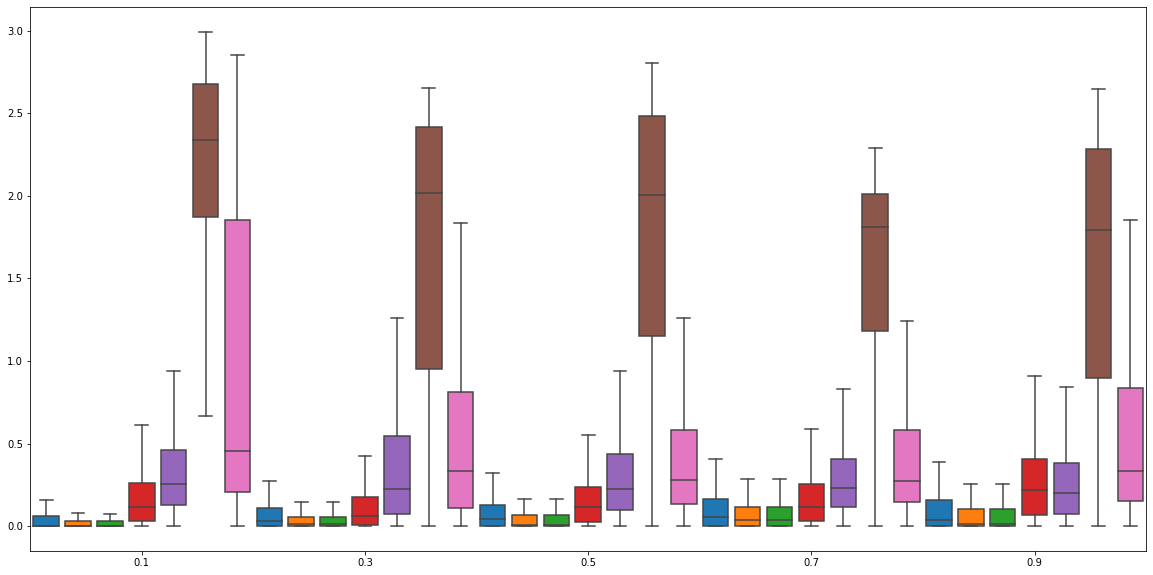

In [502]:
methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_reg, showfliers=False)
xticks = []
xticklabels = []
for i in range(len(SN_set)):
    xticks.append(int(len(methods)/2) + i * len(methods))
    xticklabels.append(f'{SN_set[i]}')
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

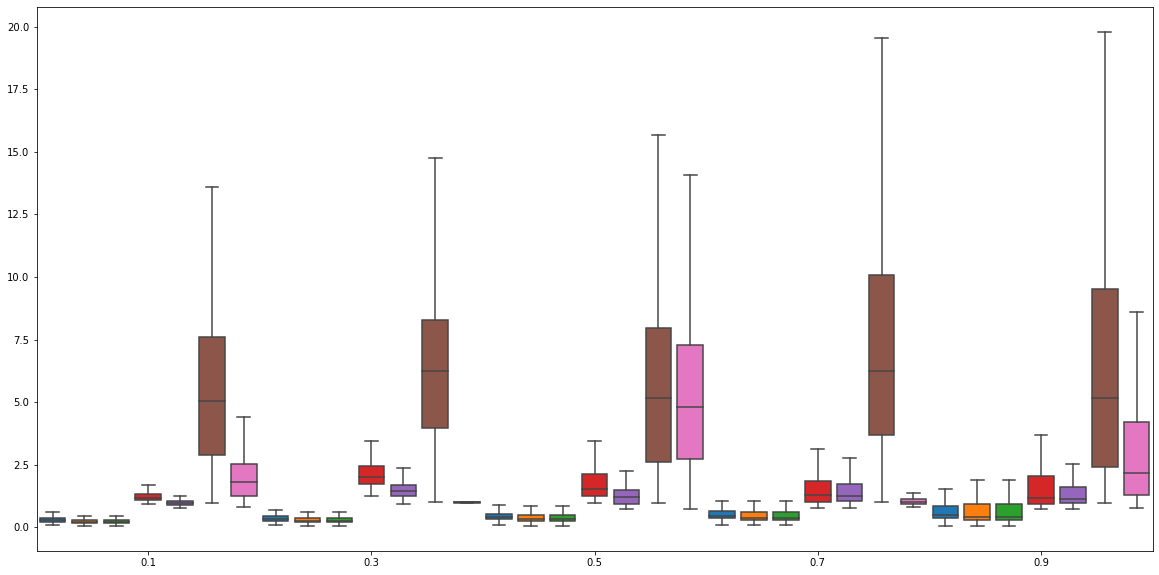

In [503]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_err, showfliers=False)
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

In [7]:
degree_set = [1, 3, 5, 7]
for deg in degree_set:
    [globals()[f"Regret_RF_{deg}"], globals()[f"Regret_ML_{deg}"], globals()[f"Regret_Ridge_{deg}"],
     globals()[f"Regret_OLS_{deg}"], globals()[f"Regret_SPO_{deg}"], globals()[f"Regret_NOGD_{deg}"], 
     globals()[f"Regret_SVMOGD_{deg}"]] = np.loadtxt(os.path.join('Degree', "RegretFK_deg{}".format(deg)))
    [globals()[f"Error_RF_{deg}"], globals()[f"Error_ML_{deg}"], globals()[f"Error_Ridge_{deg}"],
     globals()[f"Error_OLS_{deg}"], globals()[f"Error_SPO_{deg}"], globals()[f"Error_NOGD_{deg}"],
     globals()[f"Error_SVMOGD_{deg}"]] = np.loadtxt(os.path.join('Degree', "ErrorFK_deg{}".format(deg)))


In [8]:
regret = []
error = []
columns = []
for deg in degree_set:
    regret = regret + [globals()[f"Regret_RF_{deg}"], globals()[f"Regret_Ridge_{deg}"],
             globals()[f"Regret_OLS_{deg}"], globals()[f"Regret_ML_{deg}"], globals()[f"Regret_SPO_{deg}"], globals()[f"Regret_NOGD_{deg}"], 
             globals()[f"Regret_SVMOGD_{deg}"]]
    error = error + [globals()[f"Error_RF_{deg}"], globals()[f"Error_Ridge_{deg}"],
             globals()[f"Error_OLS_{deg}"], globals()[f"Error_ML_{deg}"], globals()[f"Error_SPO_{deg}"], globals()[f"Error_NOGD_{deg}"],
             globals()[f"Error_SVMOGD_{deg}"]]
    columns = columns + [f"RF, {deg}", f"Ridge, {deg}", f"OLS, {deg}", f"ML, {deg}", f"SPO, {deg}", f"NOGD, {deg}", f"SVMOGD, {deg}"]
data_reg = pd.DataFrame(np.array(regret).T, columns = columns)
data_err = pd.DataFrame(np.array(error).T, columns = columns)

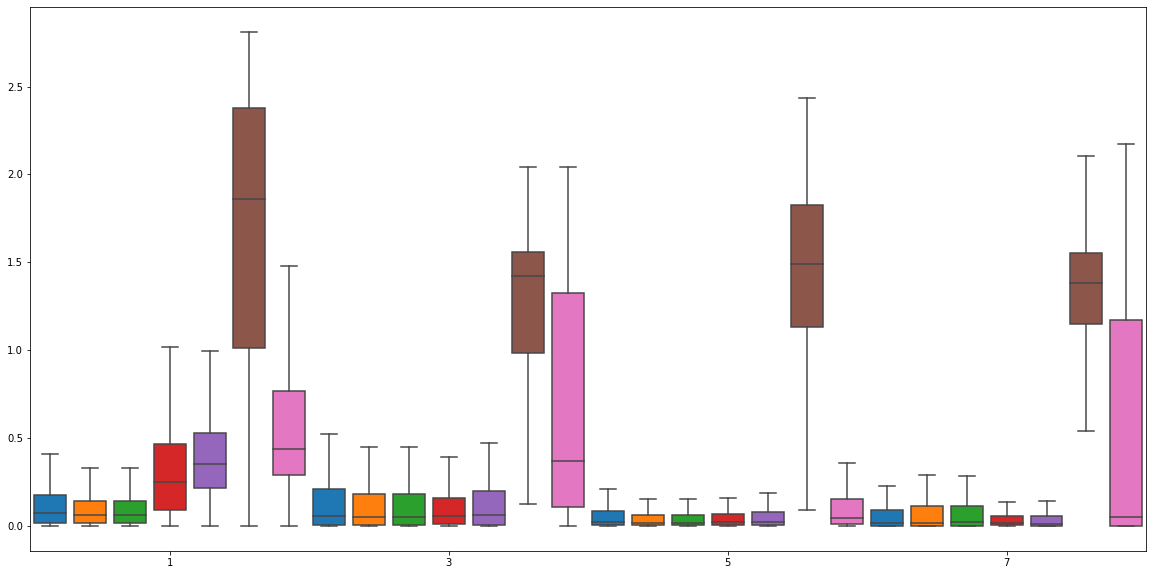

In [9]:
methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_reg, showfliers=False)
xticks = []
xticklabels = []
for i in range(len(degree_set)):
    xticks.append(int(len(methods)/2) + i * len(methods))
    xticklabels.append(f'{degree_set[i]}')
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

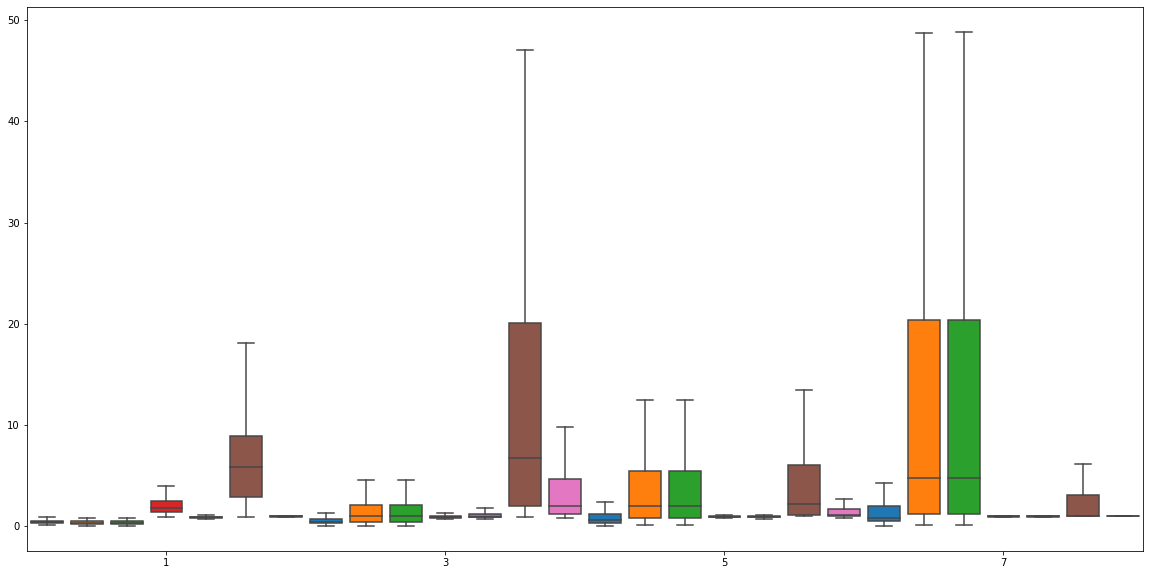

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_err, showfliers=False)
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

In [ ]:
import numpy as np
import cvxpy as cp
import sklearn
import sklearn.datasets
from sklearn.ensemble import RandomForestRegressor
import gurobipy
import mosek
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import os
import seaborn as sns
import pandas as pd
# My Code
import LearningMethod as lm
import DataGeneration as dg
import LinearProgramMethod as lpm
import OnlineMethod as om

# Generate Fractional Knapsack Samples
benchmark = 1
dim_features = 5
dim_decision = 10
price = np.random.rand(dim_decision)
lower = np.amax(price)
upper = (np.random.rand()-1)*lower + np.sum(price)
Budget = [(upper-lower)*np.random.rand() + lower]
Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_decision, dim_features))
Theta_true = -np.concatenate((Coeff_Mat, np.zeros((dim_decision+1, dim_features))), axis=0)

N = 1000
z, c, A, b = dg.GenerateFractionalKnapsack_Margin(N_samples=N, dim_features=dim_features, dim_decision=dim_decision,
                                                  price=price, Budget=Budget, Coeff_Mat=Coeff_Mat, margin=0.00)

# Compute Optimal Solutions
start = time.time()
basic, nonb, solution = lpm.ComputeBasis(c=c, A=A, b=b)
print("Time cost", time.time() - start)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [26:31<00:00,  1.59s/it]


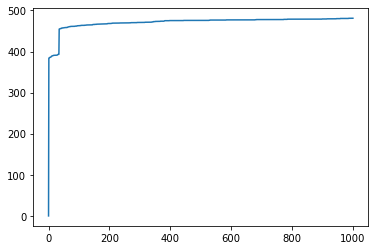

In [4]:
Regret_ML = om.OnlineMarginLearning(A=A, b=b, c=c, z=z, basic=basic, nonb=nonb,
                                    regular_const=1e-6, solved=True, solution=solution, show_figure=True, checkpoint = 1)

  2%|█▌                                                                             | 19/1000 [00:00<00:05, 184.10it/s]

Time cost 1.7151317596435547


  2%|█▌                                                                             | 19/1000 [00:00<00:05, 172.93it/s]

Time cost 1.711205005645752


  2%|█▎                                                                             | 17/1000 [00:00<00:05, 167.22it/s]

Time cost 1.7656826972961426


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:33<00:00,  6.53it/s]


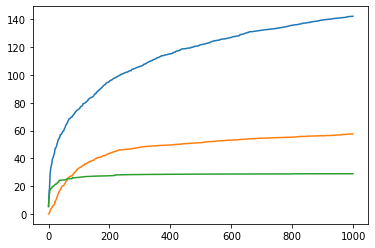

In [3]:
total_trials = 3
N = 1000
Regret_OGD = np.zeros(N)
Regret_MoM = np.zeros(N)
Regret_Perceptron = np.zeros(N)
for trial in range(total_trials):
    # Generate Fractional Knapsack Samples
    benchmark = 1
    dim_features = 5
    dim_decision = 10
    price = np.random.rand(dim_decision)
    lower = np.amax(price)
    upper = (np.random.rand()-1)*lower + np.sum(price)
    Budget = [(upper-lower)*np.random.rand() + lower]
    Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_decision, dim_features))
    Theta_true = -np.concatenate((Coeff_Mat, np.zeros((dim_decision+1, dim_features))), axis=0)
    z, c, A, b = dg.GenerateFractionalKnapsack_Margin(N_samples=N, dim_features=dim_features, dim_decision=dim_decision,
                                                      price=price, Budget=Budget, Coeff_Mat=Coeff_Mat, margin=0.00)

    # Compute Optimal Solutions
    start = time.time()
    basic, nonb, solution = lpm.ComputeBasis(c=c, A=A, b=b)
    print("Time cost", time.time() - start)
    
    # Perceptron
    Regret_tmp, _, _ = om.Perceptron(A, b, c, z, basic, nonb, solved=True, solution=solution, show_figure=False, margin=0.00)
    Regret_Perceptron += (1/total_trials)*Regret_tmp
    # OGD
    Regret_OGD += (1/total_trials)*om.OGD_MarginLearning(A=A, b=b, c=c, z=z, basic=basic, nonb=nonb,
                                                        solved=True, solution=solution, show_figure=False, step_size = 1e0, regular_const=0)
    # MoM
    Regret_MoM += (1/total_trials)*om.OnlineMarginLearning(A=A, b=b, c=c, z=z, basic=basic, nonb=nonb,
                                                        regular_const=1e-6, solved=True, solution=solution, show_figure=False, checkpoint = 10)
plt.plot(Regret_Perceptron)
plt.plot(Regret_OGD)
plt.plot(Regret_MoM)

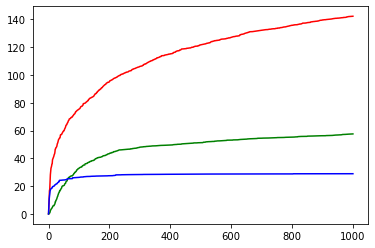

In [4]:
Regret_Perceptron = np.concatenate(([0], Regret_Perceptron))
Regret_OGD = np.concatenate(([0], Regret_OGD))
Regret_MoM = np.concatenate(([0], Regret_MoM))
plt.plot(Regret_Perceptron, color='r')
plt.plot(Regret_OGD, color='g')
plt.plot(Regret_MoM, color='b')

In [15]:
np.savetxt(os.path.join('Online', f"OGD"), Regret_OGD)
np.savetxt(os.path.join('Online', f"Perceptron"), Regret_Perceptron)
np.savetxt(os.path.join('Online', f"MoM"), Regret_MoM)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:45<00:00,  6.02it/s]


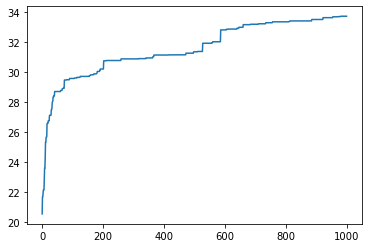

Total wrong decisions 80


In [3]:
Regret_ML = om.OnlineMarginLearning(A=A, b=b, c=c, z=z, basic=basic, nonb=nonb,
                                    regular_const=1e-6, solved=True, solution=solution, show_figure=True, checkpoint = 10)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [08:19<00:00, 200.14it/s]


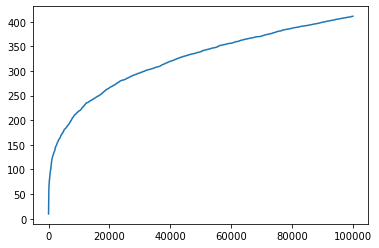

Total wrong decisions 6538


In [10]:
Regret_Perceptron, predict_cost, reduced_cost = om.Perceptron(A, b, c, z, basic, nonb, solved=True, solution=solution, show_figure=True, margin=0.05)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:25<00:00, 198.69it/s]


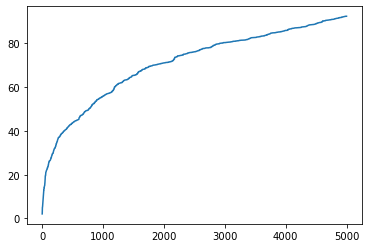

Total wrong decisions 1741


In [6]:
Regret_Perceptron, predict_cost, reduced_cost = om.Perceptron(A, b, c, z, basic, nonb, solved=True, solution=solution, show_figure=True, margin=0.05)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 199.68it/s]


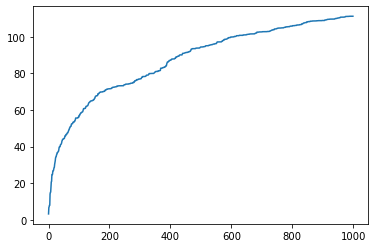

Total wrong decisions 443


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


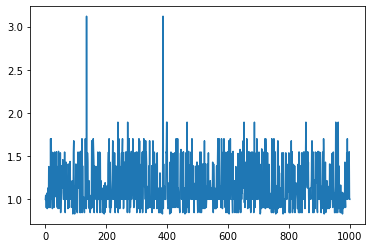

In [2]:
Regret_Perceptron, predict_cost, reduced_cost = om.Perceptron(A, b, c, z, basic, nonb, solved=True, solution=solution, show_figure=True, margin=0.05)

  1%|█                                                                              | 13/1000 [00:00<00:08, 115.14it/s]

Wrong prediction at step 0
True c
 [-1.37436573 -1.94876411 -0.22177035 -1.64759298 -0.57439838 -1.06939598
 -0.84740462 -0.84762563  0.         -0.94876411  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True solution
 [1.         1.         1.         1.         1.         0.48282607
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.51717393 1.
 0.         1.         1.        ]
Estimated solution
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         2.31735118 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]
Estimated reduced cost
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Wrong prediction at step 1
True c
 [-0.73638095 -0.67790083  0.73523891 -0.21638727  0.058

  5%|███▋                                                                           | 46/1000 [00:00<00:06, 143.50it/s]

Wrong prediction at step 28
True c
 [-1.71740646 -1.83788976 -1.56584215 -2.59982177 -0.12048331 -2.56874077
 -1.84843569 -1.00289862  0.         -0.83788976  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.02929631 -0.05961776 -0.02929631 -0.02677285  0.07342553 -0.1948463
 -0.01227459  0.07342553  0.06901954  0.06901954  0.06901954  0.02929631
  0.05961776  0.02929631  0.02677285 -0.07342553  0.1948463   0.01227459
 -0.07342553 -0.06901954 -0.06901954]
True solution
 [1.        0.0969714 1.        1.        0.        1.        1.
 1.        0.        0.        0.        0.        0.9030286 0.
 0.        1.        0.        0.        0.        1.        1.       ]
Estimated solution
 [1.         1.         1.         1.         0.         1.
 0.46594968 0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.53405032
 1.         1.         1.        ]

  8%|██████▏                                                                        | 78/1000 [00:00<00:06, 149.24it/s]

Wrong prediction at step 57
True c
 [-0.86607902 -1.05248194  0.26102971 -1.74527185 -0.18640291 -0.80456603
 -0.87289127 -1.06559574  0.         -0.05248194  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.01122735 -0.05840732 -0.01122735 -0.03224882  0.00223661 -0.03912455
 -0.10766618  0.00223661  0.06269285  0.06269285  0.06269285  0.01122735
  0.05840732  0.01122735  0.03224882 -0.00223661  0.03912455  0.10766618
 -0.00223661 -0.06269285 -0.06269285]
True solution
 [1.         1.         0.         1.         0.         0.02769678
 1.         1.         0.         0.         0.         0.
 0.         1.         0.         1.         0.97230322 0.
 0.         1.         1.        ]
Estimated solution
 [0.40191937 1.         1.         1.         0.         1.
 1.         0.         0.         0.         0.         0.59808063
 0.         0.         0.         1.         0.         0.
 1.         1

 11%|████████▌                                                                     | 110/1000 [00:00<00:05, 152.52it/s]

Wrong prediction at step 87
True c
 [-0.21814088 -0.32971014  1.41122542 -0.40982067 -0.11156927  1.10797636
 -0.37063371 -0.30324906  0.          0.67028986  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.02114847 -0.04411154  0.08066284  0.00017609 -0.04852381  0.02011598
 -0.10747234 -0.04852381  0.04379974  0.04379974  0.04379974 -0.02114847
  0.04411154 -0.08066284 -0.00017609  0.04852381 -0.02011598  0.10747234
  0.04852381 -0.04379974 -0.04379974]
True solution
 [0.55326253 1.         0.         1.         1.         0.
 1.         1.         0.         0.         0.         0.44673747
 0.         1.         0.         0.         1.         0.
 0.         1.         1.        ]
Estimated solution
 [0.         1.         0.         1.         1.         0.
 1.         1.         0.         0.         0.28268068 1.
 0.         1.         0.         0.         1.         0.
 0.         1.       

 14%|███████████                                                                   | 142/1000 [00:00<00:05, 152.66it/s]

Wrong prediction at step 114
True c
 [-1.65963657 -2.39407461 -0.67686142 -2.56460924 -0.73443805 -2.31627214
 -1.01722485 -1.63941072  0.         -1.39407461  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.04560219 -0.08328727  0.04235047 -0.06258016  0.02749881 -0.11704251
 -0.0889076   0.02749881  0.0911162   0.0911162   0.0911162   0.04560219
  0.08328727 -0.04235047  0.06258016 -0.02749881  0.11704251  0.0889076
 -0.02749881 -0.0911162  -0.0911162 ]
True solution
 [0.8215287 1.        1.        1.        0.        1.        0.
 1.        0.        0.        0.        0.1784713 0.        0.
 0.        1.        0.        1.        0.        1.        1.       ]
Estimated solution
 [0.45836419 1.         0.         1.         0.         1.
 1.         0.         0.         0.         0.         0.54163581
 0.         1.         0.         1.         0.         0.
 1.         1.         1.        

 16%|████████████▎                                                                 | 158/1000 [00:01<00:05, 145.04it/s]

Wrong prediction at step 143
True c
 [-1.98180651 -2.72352337 -1.706034   -1.07468234 -0.74171687 -1.5406267
 -1.72422749  0.1654073   0.         -1.72352337  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.00876047 -0.06071618 -0.01221036  0.02308514  0.04722863 -0.1353407
 -0.07844283  0.04722863  0.06834433  0.06834433  0.06834433  0.00876047
  0.06071618  0.01221036 -0.02308514 -0.04722863  0.1353407   0.07844283
 -0.04722863 -0.06834433 -0.06834433]
True solution
 [1.         1.         1.         1.         1.         0.15431312
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.84568688 0.
 1.         1.         1.        ]
Estimated solution
 [0.6440877 1.        1.        0.        0.        1.        1.
 0.        0.        0.        0.        0.3559123 0.        0.
 1.        1.        0.        0.        1.        1.        1.       ]

 19%|██████████████▋                                                               | 188/1000 [00:01<00:05, 141.69it/s]

Wrong prediction at step 169
True c
 [-1.36897177 -0.64164451 -1.07919959 -0.5456603   0.72732725  0.47143913
 -1.71022782  1.55063872  0.          0.35835549  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.00995975 -0.01487329  0.01659443  0.04543874  0.03545457 -0.00177037
 -0.10715643  0.03545457  0.01842982  0.01842982  0.01842982 -0.00995975
  0.01487329 -0.01659443 -0.04543874 -0.03545457  0.00177037  0.10715643
 -0.03545457 -0.01842982 -0.01842982]
True solution
 [1.         1.         1.         1.         0.         0.
 1.         0.         0.         0.         0.34703591 0.
 0.         0.         0.         1.         1.         0.
 1.         1.         1.        ]
Estimated solution
 [0.         1.         0.         0.         0.         1.
 1.         0.         0.         0.         0.35792593 1.
 0.         1.         1.         1.         0.         0.
 1.         1.         1.   

 22%|█████████████████                                                             | 219/1000 [00:01<00:05, 144.67it/s]

Wrong prediction at step 195
True c
 [-1.23620911 -1.76895872 -0.86907274 -2.03332552 -0.53274961 -2.19893876
 -1.63286362 -1.32986602  0.         -0.76895872  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.00465979 -0.06414138  0.05035467 -0.01050388  0.04953176 -0.12073187
 -0.10750435  0.05228973  0.07217433  0.07114425  0.07217433  0.00465979
  0.06414138 -0.05035467  0.01050388 -0.04953176  0.12073187  0.10750435
 -0.05228973 -0.07217433 -0.07114425]
True solution
 [1.        0.0969714 1.        1.        0.        1.        1.
 1.        0.        0.        0.        0.        0.9030286 0.
 0.        1.        0.        0.        0.        1.        1.       ]
Estimated solution
 [0.45836419 1.         0.         1.         0.         1.
 1.         0.         0.         0.         0.         0.54163581
 0.         1.         0.         1.         0.         0.
 1.         1.         1.       

 25%|███████████████████▌                                                          | 251/1000 [00:01<00:05, 147.59it/s]

Wrong prediction at step 223
True c
 [-1.14867911 -2.12310842 -1.0911914  -0.2144309  -0.97442931 -1.13137251
 -1.94251229 -0.04018111  0.         -1.12310842  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.04480758 -0.05148421  0.01129987  0.07346786  0.03956484 -0.14174638
 -0.09448582  0.13083601  0.05791838  0.02382925  0.05791838 -0.04480758
  0.05148421 -0.01129987 -0.07346786 -0.03956484  0.14174638  0.09448582
 -0.13083601 -0.05791838 -0.02382925]
True solution
 [1.         1.         1.         0.         1.         0.34390717
 1.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.65609283 0.
 1.         1.         1.        ]
Estimated solution
 [0.         1.         0.         0.         0.         1.
 1.         0.         0.         0.37362413 0.         1.
 0.         1.         1.         1.         0.         0.
 1.         1.      

 27%|████████████████████▋                                                         | 266/1000 [00:01<00:05, 143.77it/s]

Wrong prediction at step 251
True c
 [-1.23457246 -0.62181487 -0.45260668 -2.11834362  0.61275759 -0.72362025
 -1.21803422 -0.27101356  0.          0.37818513  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.02777947 -0.04002095  0.06077126 -0.03485609  0.02979554 -0.00842028
 -0.11506692 -0.00732995  0.04495468  0.05882078  0.04495468  0.02777947
  0.04002095 -0.06077126  0.03485609 -0.02979554  0.00842028  0.11506692
  0.00732995 -0.04495468 -0.05882078]
True solution
 [1.         0.58402829 1.         1.         0.         1.
 1.         0.         0.         0.         0.         0.
 0.41597171 0.         0.         1.         0.         0.
 1.         1.         1.        ]
Estimated solution
 [1.         1.         0.         1.         0.         0.02769678
 1.         1.         0.         0.         0.         0.
 0.         1.         0.         1.         0.97230322 0.
 0.         1.      

 30%|███████████████████████▍                                                      | 300/1000 [00:02<00:04, 151.24it/s]

Wrong prediction at step 280
True c
 [-0.59143472  0.33862315  1.19825918 -1.39711295  0.93005787  1.32263882
 -0.2103061   0.12437964  0.          1.33862315  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.02364854 -0.03164261  0.08822139 -0.04936398 -0.03907823  0.09106007
 -0.11498319 -0.02682111  0.03111716  0.02653921  0.03111716  0.02364854
  0.03164261 -0.08822139  0.04936398  0.03907823 -0.09106007  0.11498319
  0.02682111 -0.03111716 -0.02653921]
True solution
 [1.         0.         0.         1.         0.         0.
 1.         0.         0.         0.         1.11049222 0.
 1.         1.         0.         1.         1.         0.
 1.         1.         1.        ]
Estimated solution
 [1.         0.68928914 0.         1.         1.         0.
 1.         1.         0.         0.         0.         0.
 0.31071086 1.         0.         0.         1.         0.
 0.         1.         1.   

 33%|█████████████████████████▉                                                    | 333/1000 [00:02<00:04, 151.24it/s]

Wrong prediction at step 311
True c
 [-0.06195207  0.03923972  1.42140555  0.74335894  0.1011918   2.32790837
 -0.51664238  0.90650282  0.          1.03923972  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.0504835  -0.02358561  0.06408649  0.05118789 -0.05786443  0.04992189
 -0.1067956   0.06762548  0.02116323 -0.02570635  0.02116323 -0.0504835
  0.02358561 -0.06408649 -0.05118789  0.05786443 -0.04992189  0.1067956
 -0.06762548 -0.02116323  0.02570635]
True solution
 [1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         1.23422427 0.
 1.         1.         1.         1.         1.         0.
 1.         1.         1.        ]
Estimated solution
 [0.         1.         0.         0.         1.         0.
 1.         0.         0.         0.79773032 0.         1.
 0.         1.         1.         0.         1.         0.
 1.         1.         0.20226

 35%|███████████████████████████▎                                                  | 350/1000 [00:02<00:04, 152.02it/s]

True solution
 [1.         1.         1.         1.         0.         1.
 0.         0.74514525 0.         0.         0.         0.
 0.         0.         0.         1.         0.         1.
 0.25485475 1.         1.        ]
Estimated solution
 [1.         1.         0.         1.         0.         0.57595229
 1.         0.         0.         0.         0.         0.
 0.         1.         0.         1.         0.42404771 0.
 1.         1.         1.        ]
Estimated reduced cost
 [0.         0.         0.         0.         3.41423352 0.
 3.12146223 0.         3.12146223 3.12146223 1.56073111 3.12146223
 3.12146223 3.12146223 3.12146223 0.         3.41423352 0.
 0.         0.         0.        ]
Wrong prediction at step 339
True c
 [-1.53023636 -1.24313339 -1.13942082 -2.30478551  0.28710298 -1.62686699
 -1.60918446 -0.48744617  0.         -0.24313339  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c

 38%|█████████████████████████████▋                                                | 381/1000 [00:02<00:04, 137.58it/s]

Wrong prediction at step 364
True c
 [-0.50899169  0.36821429 -0.39021828 -1.44848492  0.87720597 -0.45250554
 -1.88122659 -0.06228726  0.          1.36821429  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.0272306  -0.01603136  0.08200493  0.02729304  0.04992724 -0.00385941
 -0.14211353 -0.01141511  0.02069246  0.04360339  0.02069246 -0.0272306
  0.01603136 -0.08200493 -0.02729304 -0.04992724  0.00385941  0.14211353
  0.01141511 -0.02069246 -0.04360339]
True solution
 [1.         0.         1.         1.         0.         1.
 1.         1.         0.         0.         0.07123681 0.
 1.         0.         0.         1.         0.         0.
 0.         1.         1.        ]
Estimated solution
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 1.25795001e-04 1.00000000e+00
 0.00000000e+00 1.00000

 41%|███████████████████████████████▉                                              | 409/1000 [00:02<00:04, 129.18it/s]

Wrong prediction at step 387
True c
 [-1.93216014 -2.9065003  -0.40357754 -1.56820753 -0.97434016 -1.01396508
 -0.4714174  -0.61038755  0.         -1.9065003   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.05056969 -0.08493429  0.00865223 -0.05281548 -0.01335417 -0.09327384
 -0.06240115  0.09456701  0.08999265  0.04968487  0.08999265  0.05056969
  0.08493429 -0.00865223  0.05281548  0.01335417  0.09327384  0.06240115
 -0.09456701 -0.08999265 -0.04968487]
True solution
 [1.         1.         1.         1.         1.         0.
 0.         0.         0.         0.70241259 0.         0.
 0.         0.         0.         0.         1.         1.
 1.         1.         0.29758741]
Estimated solution
 [0.45836419 1.         0.         1.         0.         1.
 1.         0.         0.         0.         0.         0.54163581
 0.         1.         0.         1.         0.         0.
 1.         1.      

 42%|████████████████████████████████▉                                             | 422/1000 [00:02<00:04, 128.89it/s]

Wrong prediction at step 410
True c
 [-0.49859413 -0.05219131 -0.31770465  0.2462608   0.44640282  0.8735531
 -1.81911052  1.19125775  0.          0.94780869  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.06080151 -0.0086248   0.0441076   0.08859856  0.02254066 -0.00674934
 -0.12257841  0.06106122  0.01082717 -0.00355998  0.01082717 -0.06080151
  0.0086248  -0.0441076  -0.08859856 -0.02254066  0.00674934  0.12257841
 -0.06106122 -0.01082717  0.00355998]
True solution
 [1.         1.         1.         0.         0.         0.
 1.         0.         0.         0.         0.47076796 0.
 0.         0.         1.         1.         1.         0.
 1.         1.         1.        ]
Estimated solution
 [0.         1.         0.         0.         0.         1.
 1.         0.         0.         0.37362413 0.         1.
 0.         1.         1.         1.         0.         0.
 1.         1.         0.6263

 45%|███████████████████████████████████▏                                          | 451/1000 [00:03<00:04, 135.84it/s]

Wrong prediction at step 435
True c
 [-1.66737309 -0.85251545 -0.128255   -0.70754927  0.81485764  1.64642646
 -0.46088191  1.77468146  0.          0.14748455  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.04053565 -0.02849807  0.01308691 -0.02162778 -0.02624326  0.06693391
 -0.08267249  0.03212337  0.02865741  0.00685789  0.02865741  0.04053565
  0.02849807 -0.01308691  0.02162778  0.02624326 -0.06693391  0.08267249
 -0.03212337 -0.02865741 -0.00685789]
True solution
 [1.         1.         1.         1.         0.         0.
 1.         0.         0.         0.         0.34703591 0.
 0.         0.         0.         1.         1.         0.
 1.         1.         1.        ]
Estimated solution
 [1.         1.         0.         1.         1.         0.
 1.         0.         0.         0.13522851 0.         0.
 0.         1.         0.         0.         1.         0.
 1.         1.         0.864

 48%|█████████████████████████████████████▌                                        | 481/1000 [00:03<00:03, 140.17it/s]

Wrong prediction at step 462
True c
 [-0.90517248 -1.38170346 -0.39275059 -0.16574686 -0.47653098 -0.12985595
 -1.48757811  0.26289464  0.         -0.38170346  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.03692929 -0.04191242  0.02892248  0.05554498  0.0130901  -0.07372803
 -0.09950488  0.09824311  0.04579929  0.01399525  0.04579929 -0.03692929
  0.04191242 -0.02892248 -0.05554498 -0.0130901   0.07372803  0.09950488
 -0.09824311 -0.04579929 -0.01399525]
True solution
 [1.         1.         1.         1.         1.         0.
 1.         0.         0.         0.10512406 0.         0.
 0.         0.         0.         0.         1.         0.
 1.         1.         0.89487594]
Estimated solution
 [0.         1.         0.         0.         0.         1.
 1.         0.         0.         0.37362413 0.         1.
 0.         1.         1.         1.         0.         0.
 1.         1.         0.626

 51%|███████████████████████████████████████▉                                      | 512/1000 [00:03<00:03, 144.31it/s]

Wrong prediction at step 489
True c
 [-1.20797929 -1.64560391 -1.15844572 -0.74138003 -0.43762462 -1.12947109
 -1.95046643  0.02897464  0.         -0.64560391  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.02870112 -0.04380514  0.02212433  0.0526972   0.04837688 -0.10883936
 -0.10346167  0.09117862  0.05031937  0.03433323  0.05031937 -0.02870112
  0.04380514 -0.02212433 -0.0526972  -0.04837688  0.10883936  0.10346167
 -0.09117862 -0.05031937 -0.03433323]
True solution
 [1.         1.         1.         1.         1.         0.15431312
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.84568688 0.
 1.         1.         1.        ]
Estimated solution
 [0.         1.         0.         0.         0.         1.
 1.         0.         0.         0.         0.35792593 1.
 0.         1.         1.         1.         0.         0.
 1.         1.      

 54%|██████████████████████████████████████████▎                                   | 542/1000 [00:03<00:03, 142.08it/s]

Wrong prediction at step 517
True c
 [-0.624613   -0.64118312 -0.50411144 -0.76182418 -0.01657011 -0.65789274
 -1.87949844 -0.1537813   0.          0.35881688  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.04329662 -0.03168452  0.05650863  0.05330583  0.04034561 -0.06494039
 -0.12312253  0.05454483  0.03677468  0.03147137  0.03677468 -0.04329662
  0.03168452 -0.05650863 -0.05330583 -0.04034561  0.06494039  0.12312253
 -0.05454483 -0.03677468 -0.03147137]
True solution
 [1.         0.58402829 1.         1.         0.         1.
 1.         0.         0.         0.         0.         0.
 0.41597171 0.         0.         1.         0.         0.
 1.         1.         1.        ]
Estimated solution
 [0.         1.         0.         0.         0.         1.
 1.         0.         0.         0.         0.35792593 1.
 0.         1.         1.         1.         0.         0.
 1.         1.         1.   

 56%|███████████████████████████████████████████▍                                  | 557/1000 [00:03<00:03, 143.06it/s]

Wrong prediction at step 543
True c
 [-1.87854884 -1.72328816 -0.92564224 -1.78793878  0.15526068 -0.6797715
 -1.0470934   0.24587075  0.         -0.72328816  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.04548053 -0.05232377  0.01788844 -0.03562271  0.02110876 -0.03768141
 -0.08716574  0.03999037  0.05751303  0.05046089  0.05751303  0.04548053
  0.05232377 -0.01788844  0.03562271 -0.02110876  0.03768141  0.08716574
 -0.03999037 -0.05751303 -0.05046089]
True solution
 [1.         1.         1.         1.         0.         0.53176152
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.46823848 0.
 1.         1.         1.        ]
Estimated solution
 [1.         1.         0.         1.         0.         0.57595229
 1.         0.         0.         0.         0.         0.
 0.         1.         0.         1.         0.42404771 0.
 1.         1

 59%|█████████████████████████████████████████████▊                                | 587/1000 [00:04<00:02, 145.36it/s]

Wrong prediction at step 570
True c
 [-0.99075011 -0.78791273 -0.05928784 -0.8159951   0.20283738  0.31830455
 -1.06853773  0.37759239  0.          0.21208727  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.00403137 -0.03647005  0.04464909  0.00982144  0.00123201 -0.00860303
 -0.10400177  0.04454079  0.03913435  0.02295883  0.03913435 -0.00403137
  0.03647005 -0.04464909 -0.00982144 -0.00123201  0.00860303  0.10400177
 -0.04454079 -0.03913435 -0.02295883]
True solution
 [1.         1.         1.         1.         0.         0.
 1.         0.         0.         0.         0.34703591 0.
 0.         0.         0.         1.         1.         0.
 1.         1.         1.        ]
Estimated solution
 [0.21841798 1.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.78158202
 0.         1.         1.         0.         0.         0.
 1.         1.      

 62%|████████████████████████████████████████████████▏                             | 617/1000 [00:04<00:02, 144.16it/s]

Wrong prediction at step 598
True c
 [-1.69952413 -1.03864532 -1.22602292 -1.8495636   0.66087881 -0.71518358
 -1.52649879  0.51083934  0.         -0.03864532  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.03062695 -0.03441953  0.028039   -0.0148115   0.04651916 -0.02242031
 -0.10546477  0.01473244  0.04013923  0.05201134  0.04013923  0.03062695
  0.03441953 -0.028039    0.0148115  -0.04651916  0.02242031  0.10546477
 -0.01473244 -0.04013923 -0.05201134]
True solution
 [1.         1.         1.         1.         0.         0.53176152
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.46823848 0.
 1.         1.         1.        ]
Estimated solution
 [1.         1.         0.         1.         0.         0.57595229
 1.         0.         0.         0.         0.         0.
 0.         1.         0.         1.         0.42404771 0.
 1.         

 65%|██████████████████████████████████████████████████▌                           | 648/1000 [00:04<00:02, 145.47it/s]

Wrong prediction at step 624
True c
 [-1.65963725 -1.19532224 -1.25555116 -1.59667049  0.464315   -0.7282694
 -1.59591392  0.52728176  0.         -0.19532224  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.0208794  -0.03574115  0.02325455 -0.00143194  0.04615975 -0.03720168
 -0.10326037  0.03138221  0.04152885  0.04704815  0.04152885  0.0208794
  0.03574115 -0.02325455  0.00143194 -0.04615975  0.03720168  0.10326037
 -0.03138221 -0.04152885 -0.04704815]
True solution
 [1.         1.         1.         1.         0.         0.53176152
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.46823848 0.
 1.         1.         1.        ]
Estimated solution
 [0.70053252 1.         0.         0.         0.         1.
 1.         0.         0.         0.         0.         0.29946748
 0.         1.         1.         1.         0.         0.
 1.         1.

 68%|████████████████████████████████████████████████████▉                         | 679/1000 [00:04<00:02, 148.55it/s]

Wrong prediction at step 652
True c
 [-1.85616382 -1.38720813 -0.59212006 -2.04056396  0.46895569 -0.30756451
 -0.73595624  0.28455555  0.         -0.38720813  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.06102171 -0.0502444   0.02825714 -0.05985737  0.00817407  0.00029909
 -0.08875604  0.01382574  0.05437267  0.05226181  0.05437267  0.06102171
  0.0502444  -0.02825714  0.05985737 -0.00817407 -0.00029909  0.08875604
 -0.01382574 -0.05437267 -0.05226181]
True solution
 [1.         1.         1.         1.         0.         0.53176152
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.46823848 0.
 1.         1.         1.        ]
Estimated solution
 [1.         1.         0.         1.         0.         0.57595229
 1.         0.         0.         0.         0.         0.
 0.         1.         0.         1.         0.42404771 0.
 1.         

 69%|██████████████████████████████████████████████████████▏                       | 694/1000 [00:04<00:02, 148.70it/s]

Wrong prediction at step 680
True c
 [-0.218722   -0.36925686  0.77102275 -0.8090452  -0.15053486  0.03016469
 -1.01025525 -0.74085806  0.          0.63074314  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.03261438 -0.04300654  0.0846968   0.0150584  -0.00892768 -0.02433364
 -0.11990655  0.03939114  0.0454148   0.02736806  0.0454148  -0.03261438
  0.04300654 -0.0846968  -0.0150584   0.00892768  0.02433364  0.11990655
 -0.03939114 -0.0454148  -0.02736806]
True solution
 [0.55326253 1.         0.         1.         1.         0.
 1.         1.         0.         0.         0.         0.44673747
 0.         1.         0.         0.         1.         0.
 0.         1.         1.        ]
Estimated solution
 [0.         1.         0.         0.         1.         1.
 1.         0.         0.         0.         0.11159719 1.
 0.         1.         1.         0.         0.         0.
 1.         1.      

 73%|████████████████████████████████████████████████████████▋                     | 726/1000 [00:05<00:01, 150.17it/s]

Wrong prediction at step 709
True c
 [-1.43773903 -1.4788977  -1.14277551 -2.37253527 -0.04115867 -2.11873042
 -1.70503648 -0.97595491  0.         -0.4788977   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.02005583 -0.05540915  0.04879012 -0.02249945  0.06032488 -0.09350105
 -0.11153768  0.02517009  0.06358774  0.0767178   0.06358774  0.02005583
  0.05540915 -0.04879012  0.02249945 -0.06032488  0.09350105  0.11153768
 -0.02517009 -0.06358774 -0.0767178 ]
True solution
 [1.        0.0969714 1.        1.        0.        1.        1.
 1.        0.        0.        0.        0.        0.9030286 0.
 0.        1.        0.        0.        0.        1.        1.       ]
Estimated solution
 [0.45836419 1.         0.         1.         0.         1.
 1.         0.         0.         0.         0.         0.54163581
 0.         1.         0.         1.         0.         0.
 1.         1.         1.       

 76%|███████████████████████████████████████████████████████████                   | 757/1000 [00:05<00:01, 148.53it/s]

Wrong prediction at step 737
True c
 [-0.21180005  0.36911662  0.17148995  0.10786384  0.58091667  1.07207051
 -1.61671     0.90058056  0.          1.36911662  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.06134264 -0.00769101  0.06459356  0.07642399  0.01137091  0.01606028
 -0.12996291  0.04064123  0.00903807 -0.00189419  0.00903807 -0.06134264
  0.00769101 -0.06459356 -0.07642399 -0.01137091 -0.01606028  0.12996291
 -0.04064123 -0.00903807  0.00189419]
True solution
 [1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         1.23422427 0.
 1.         1.         1.         1.         1.         0.
 1.         1.         1.        ]
Estimated solution
 [0.         1.         0.         0.         0.         0.
 1.         0.         0.         1.         0.05255764 1.
 0.         1.         1.         1.         1.         0.
 1.         1.         0.   

 79%|█████████████████████████████████████████████████████████████▍                | 787/1000 [00:05<00:01, 145.50it/s]

Wrong prediction at step 764
True c
 [-1.22919294 -0.36420432  0.25464821 -0.49582933  0.86498863  1.85300045
 -0.51615885  1.59835224  0.          0.63579568  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.01999118 -0.02254116  0.03193213 -0.00718699 -0.02992219  0.07656664
 -0.09416672  0.02512355  0.02201957  0.00146038  0.02201957  0.01999118
  0.02254116 -0.03193213  0.00718699  0.02992219 -0.07656664  0.09416672
 -0.02512355 -0.02201957 -0.00146038]
True solution
 [1.         1.         0.         1.         0.         0.
 1.         0.         0.         0.         0.37587549 0.
 0.         1.         0.         1.         1.         0.
 1.         1.         1.        ]
Estimated solution
 [1.         1.         0.         1.         1.         0.
 1.         0.         0.         0.13522851 0.         0.
 0.         1.         0.         0.         1.         0.
 1.         1.         0.864

 80%|██████████████████████████████████████████████████████████████▌               | 802/1000 [00:05<00:01, 144.63it/s]

Wrong prediction at step 791
True c
 [-1.87101997 -1.68261112  0.11046729 -2.4443859   0.18840885 -0.27448979
 -0.01851274 -0.38495708  0.         -0.68261112  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.08750538 -0.06941947  0.03978135 -0.10801175 -0.02462252  0.01016297
 -0.07772182  0.00714304  0.07258514  0.06072093  0.07258514  0.08750538
  0.06941947 -0.03978135  0.10801175  0.02462252 -0.01016297  0.07772182
 -0.00714304 -0.07258514 -0.06072093]
True solution
 [1.         1.         0.         1.         0.         0.
 0.         1.         0.         0.61615665 0.         0.
 0.         1.         0.         1.         1.         1.
 0.         1.         0.38384335]
Estimated solution
 [1.         1.         0.         1.         1.         0.19850388
 1.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.80149612 0.
 1.         1.      

 84%|█████████████████████████████████████████████████████████████████▏            | 836/1000 [00:05<00:01, 147.86it/s]

Wrong prediction at step 818
True c
 [-1.35097859 -1.16798962 -1.337294   -2.24090008  0.18298896 -2.04422653
 -1.98631541 -0.70693253  0.         -0.16798962  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.00826946 -0.04494846  0.04976588 -0.00406168  0.07298334 -0.08777065
 -0.11957067  0.01948833  0.05328235  0.07326236  0.05328235  0.00826946
  0.04494846 -0.04976588  0.00406168 -0.07298334  0.08777065  0.11957067
 -0.01948833 -0.05328235 -0.07326236]
True solution
 [1.        0.0969714 1.        1.        0.        1.        1.
 1.        0.        0.        0.        0.        0.9030286 0.
 0.        1.        0.        0.        0.        1.        1.       ]
Estimated solution
 [0.45836419 1.         0.         1.         0.         1.
 1.         0.         0.         0.         0.         0.54163581
 0.         1.         0.         1.         0.         0.
 1.         1.         1.       

 87%|███████████████████████████████████████████████████████████████████▋          | 868/1000 [00:05<00:00, 149.84it/s]


Wrong prediction at step 848
True c
 [-0.25345155  0.37054746  1.55400738 -0.12131912  0.623999    2.31013882
 -0.19254107  0.75613143  0.          1.37054746  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.01394232 -0.02400155  0.07734402  0.00114392 -0.06094633  0.09265213
 -0.10984132  0.01819331  0.02139077 -0.00816732  0.02139077 -0.01394232
  0.02400155 -0.07734402 -0.00114392  0.06094633 -0.09265213  0.10984132
 -0.01819331 -0.02139077  0.00816732]
True solution
 [1.         0.         0.         1.         0.         0.
 1.         0.         0.         0.         1.11049222 0.
 1.         1.         0.         1.         1.         0.
 1.         1.         1.        ]
Estimated solution
 [0.         1.         0.         0.         1.         0.
 1.         0.         0.         0.79773032 0.         1.
 0.         1.         1.         0.         1.         0.
 1.         1.         0.20

 90%|██████████████████████████████████████████████████████████████████████        | 899/1000 [00:06<00:00, 148.99it/s]

Wrong prediction at step 875
True c
 [-1.78264619 -2.14551997 -0.21046346 -2.73090455 -0.36287377 -1.52159558
 -0.42781726 -1.31113213  0.         -1.14551997  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.07322281 -0.08219512  0.04522492 -0.09796479 -0.00016392 -0.05962294
 -0.08233926  0.02517016  0.08799202  0.07852993  0.08799202  0.07322281
  0.08219512 -0.04522492  0.09796479  0.00016392  0.05962294  0.08233926
 -0.02517016 -0.08799202 -0.07852993]
True solution
 [1.         1.         1.         1.         0.         0.86027448
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         1.         0.13972552 1.
 0.         1.         1.        ]
Estimated solution
 [1.         1.         0.         1.         0.         0.57595229
 1.         0.         0.         0.         0.         0.
 0.         1.         0.         1.         0.42404771 0.
 1.         

 92%|███████████████████████████████████████████████████████████████████████▎      | 915/1000 [00:06<00:00, 146.88it/s]

Wrong prediction at step 903
True c
 [-0.48658169 -1.02952286  0.93889304 -0.44250799 -0.54294118  0.44002556
 -0.57452528 -0.49886748  0.         -0.02952286  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.02060485 -0.0544844   0.06340737  0.0066794  -0.03536773 -0.02899198
 -0.09863694  0.07193854  0.05583532  0.01575719  0.05583532 -0.02060485
  0.0544844  -0.06340737 -0.0066794   0.03536773  0.02899198  0.09863694
 -0.07193854 -0.05583532 -0.01575719]
True solution
 [0.55326253 1.         0.         1.         1.         0.
 1.         1.         0.         0.         0.         0.44673747
 0.         1.         0.         0.         1.         0.
 0.         1.         1.        ]
Estimated solution
 [0.         1.         0.         0.         1.         1.
 1.         0.         0.         0.11649171 0.         1.
 0.         1.         1.         0.         0.         0.
 1.         1.      

 95%|█████████████████████████████████████████████████████████████████████████▊    | 947/1000 [00:06<00:00, 146.61it/s]

Wrong prediction at step 930
True c
 [-0.26252516  0.14858143 -0.06340125 -0.95157588  0.41110659 -0.34134538
 -1.80087609 -0.27794413  0.          1.14858143  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.04668219 -0.02224619  0.08274715  0.0451782   0.03615192 -0.02549289
 -0.13816124  0.01820875  0.02637301  0.03307465  0.02637301 -0.04668219
  0.02224619 -0.08274715 -0.0451782  -0.03615192  0.02549289  0.13816124
 -0.01820875 -0.02637301 -0.03307465]
True solution
 [1.         0.         1.         1.         0.         1.
 1.         1.         0.         0.         0.07123681 0.
 1.         0.         0.         1.         0.         0.
 0.         1.         1.        ]
Estimated solution
 [0.         1.         0.         0.         0.         1.
 1.         0.         0.         0.         0.35792593 1.
 0.         1.         1.         1.         0.         0.
 1.         1.         1.   

 98%|████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [00:06<00:00, 145.39it/s]

Wrong prediction at step 957
True c
 [-1.06840021 -1.55660173 -0.12228679 -0.92208694 -0.48820152 -0.46417504
 -1.05388658 -0.34188825  0.         -0.55660173  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [ 0.00467446 -0.05582054  0.03947954  0.00559663  0.00185968 -0.06544791
 -0.09468994  0.07495167  0.05989663  0.0325973   0.05989663 -0.00467446
  0.05582054 -0.03947954 -0.00559663 -0.00185968  0.06544791  0.09468994
 -0.07495167 -0.05989663 -0.0325973 ]
True solution
 [1.         1.         1.         1.         1.         0.
 1.         0.28146205 0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.71853795 1.         1.        ]
Estimated solution
 [0.21841798 1.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.78158202
 0.         1.         1.         0.         0.         0.
 1.         1.      

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.82it/s]


Wrong prediction at step 984
True c
 [-1.84663956 -2.49396895 -1.54473387 -1.99033312 -0.64732939 -2.33575682
 -1.69809431 -0.79102295  0.         -1.49396895  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Estimated c
 [-0.02251609 -0.0683235   0.01557028 -0.01129056  0.05749747 -0.13988329
 -0.0903299   0.07621471  0.0772149   0.07022414  0.0772149   0.02251609
  0.0683235  -0.01557028  0.01129056 -0.05749747  0.13988329  0.0903299
 -0.07621471 -0.0772149  -0.07022414]
True solution
 [1.         1.         1.         1.         0.         1.
 0.46594968 0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.53405032
 1.         1.         1.        ]
Estimated solution
 [0.45836419 1.         0.         1.         0.         1.
 1.         0.         0.         0.         0.         0.54163581
 0.         1.         0.         1.         0.         0.
 1.         1

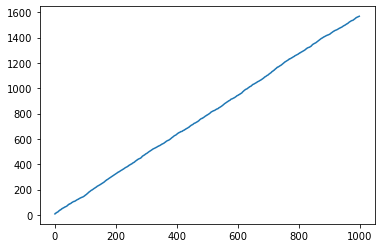

Total wrong decisions 996


In [2]:
Regret_Perceptron, predict_cost, reduced_cost = om.Perceptron_Alt(A, b, c, z, basic, nonb, solved=True, solution=solution, show_figure=True, margin=0.05, isDebug=True)

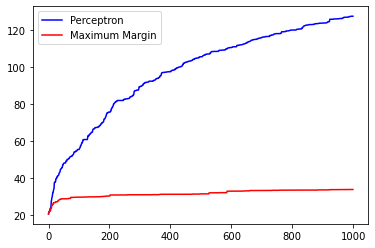

In [8]:
plt.plot(Regret_Perceptron, color='b', label='Perceptron')
plt.plot(Regret_ML, color='r', label='Maximum Margin')
plt.legend()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 171.21it/s]


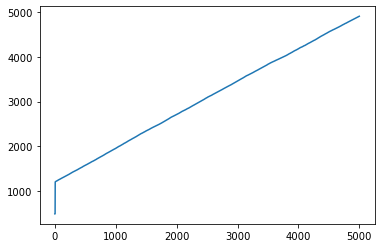

In [5]:
Regret_Perceptron, predict_cost, reduced_cost = om.Perceptron(A, b, mod_c, z, basic, nonb, solved=True, solution=solution, show_figure=True)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:28:04<00:00,  1.06s/it]


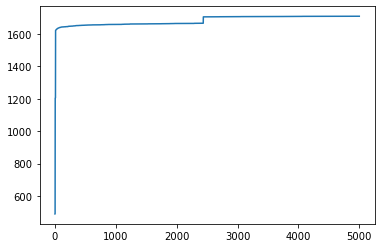

In [6]:
Regret_ML = om.OnlineMarginLearning(A=A, b=b, c=mod_c, z=z, basic=basic, nonb=nonb,
                                    regular_const=1e-6, solved=True, solution=solution, show_figure=True, checkpoint = 20)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:59<00:00,  5.58it/s]


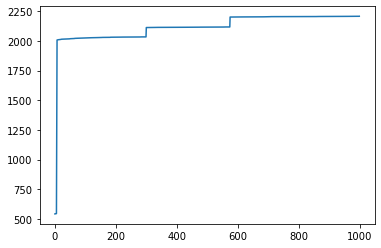

In [4]:
Regret_ML = om.OnlineMarginLearning(A=A, b=b, c=mod_c, z=z, basic=basic, nonb=nonb,
                                    regular_const=1e-6, solved=True, solution=solution, show_figure=True, checkpoint = 10)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:50<00:00,  5.87it/s]


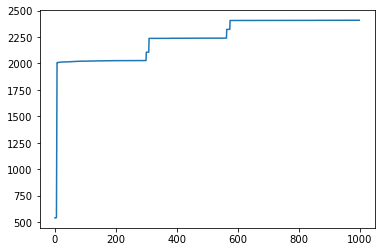

In [5]:
Regret_ML = om.OnlineMarginLearning(A=A, b=b, c=mod_c, z=z, basic=basic, nonb=nonb,
                                    regular_const=1e-4, solved=True, solution=solution, show_figure=True, checkpoint = 10)